In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dense

In [1]:
# Importing the Keras libraries and packages
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import os, json
current_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
current_device.type

'cuda'

In [3]:
dress_patterns_df = pd.read_csv('C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/dress-pattern-recognition-using-CNN/dress_patterns.csv')
dress_patterns = dress_patterns_df.values
dress_patterns_df.head()

,_unit_id,category,category:confidence,image_url
0,851505458,ikat,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...


In [3]:
dress_patterns_df['category'].unique()

array(['ikat', 'plain', 'polka dot', 'geometry', 'floral', 'squares',
       'scales', 'animal', 'OTHER', 'stripes', 'tribal', 'houndstooth',
       'cartoon', 'chevron', 'stars', 'letter_numb', 'skull'],
      dtype=object)

'cuda'

In [3]:
def convertImageToTensor(image_name):
    original_image = Image.open(image_name).convert("RGB")
    cropped_image = original_image.copy()
    transform =  transforms.ToTensor()
    tensor_image = transform(cropped_image)
    
    resize = transforms.Resize([224, 224])
    return resize(tensor_image.type(torch.FloatTensor))

In [ ]:
tdata = {'id':[],'category':[],'image':[]}
for i in range(len(dress_patterns_df)):
    j = np.random.randint(0,len(dress_patterns_df))
    try:
        img = convertImageToTensor("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/temp/dress-pattern-recognition-using-CNN/dataset_category/"+dress_patterns_df['category'][j]+"/"+str(dress_patterns_df['_unit_id'][j])+".jpg")
        category = dress_patterns_df['category'][j]
        item_id = dress_patterns_df['_unit_id'][j]
        tdata['id'].append(item_id)
        tdata['category'].append(category)
        tdata['image'].append(img)
    except Exception as e:
        # print(e)
        pass

In [7]:
len(tdata['id'])

12401

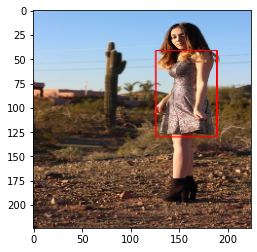

In [8]:
plt.imshow(np.array(tdata['image'][np.random.randint(0,len(tdata))]).transpose(1,2,0))
plt.show()

In [9]:
sum(dress_patterns_df['category']=='ikat')

355

In [10]:
tdata['category'][2]

'plain'

In [11]:
keyMap = {'ikat':0, 'plain':1, 'polka dot':2, 'geometry':3, 'floral':4, 'squares':5,
       'scales':6, 'animal':7, 'OTHER':8, 'stripes':9, 'tribal':10, 'houndstooth':11,
       'cartoon':12, 'chevron':13, 'stars':14, 'letter_numb':15, 'skull':16}

In [13]:
keyMap[tdata['category'][12]]

4

In [14]:
my_data = list()
for i in range(len(tdata['image'])):
    my_data.append((tdata['image'][i],keyMap[tdata['category'][i]]))
# tensor_data = torch.utils.data.DataLoader(my_data, batch_size=10, shuffle=True)

In [15]:
len(my_data)

12401

In [23]:
class myConvNet(torch.nn.Module):
    def __init__(self):
        #defining all the necessary layers in the network here
        torch.nn.Module.__init__(self)
        self.first_conv_layer = torch.nn.Conv2d(3,15,5)
        self.max_pooling_layer = torch.nn.MaxPool2d(2)#stride 1
        self.relu = torch.nn.functional.relu
        self.second_conv_layer = torch.nn.Conv2d(15,30,5)
        self.third_conv_layer = torch.nn.Conv2d(30,45,5)
        # self.fourth_conv_layer = torch.nn.Conv2d(45,60,5)
        
        

        # the output of the cov2d layer is (batchsize, outputlayers , x , y)
        # which in our case is (batchsize x 30 x 53 x 53) for image size 244
        self.AL1 = torch.nn.Linear(30*53*53,1024)
        # self.AL1 = torch.nn.Linear(60*10*10,1024) # four conv layers
        # self.AL1 = torch.nn.Linear(45*24*24,1024) # three conv layers
        self.AL2 = torch.nn.Linear(1024,128)
        # self.AL3 = torch.nn.Linear(128,64)
        self.AL3 = torch.nn.Linear(128,17)
        # self.AL4 = torch.nn.Linear(64,17)
        
        
    def forward(self,x):
        
        #Conv -> Maxpooling -> ReLU -> Conv -> Dropout -> Maxpool -> ReLU
        
        
        # print("input dims",x.size())
        x = self.first_conv_layer(x)
        # print("input dims after conv1",x.size())
        x = self.max_pooling_layer(x)
        # print("input dims after maxpool1",x.size())
        x = self.relu(x)
        x = self.second_conv_layer(x)
        # print("input dims after conv2",x.size())
        # x = self.DO_layer(x)
        x = self.max_pooling_layer(x)
        # print("input dims after maxpool1",x.size())
        x = self.relu(x)
        # print("before flatten",x.size())
        
#         x = self.third_conv_layer(x)
        
#         x = self.max_pooling_layer(x)
                
#         x = self.relu(x)
        
#         x = self.fourth_conv_layer(x)
        
#         x = self.max_pooling_layer(x)
                
#         x = self.relu(x)
        
        
        # print("before flatten",x.size())
        # return 1,2
        
        
        #should flatten the input to fit the affinelayer (1-dimensional input) currently the input is 3D ( 30 x 53 x 53 )
        x = x.view(-1,30*53*53)
        

        # with 3 conv layers
        # x = x.view(-1,45*24*24)

        
        
        
        #should flatten the input to fit the affinelayer (1-dimensional input)
        #after adding more conv layers, currently the input is 3D ( 60 x 10 x 10 ) with  conv layers
        # x = x.view(-1,60*10*10)
        # print("after flatten",x.size())
        # x = torch.flatten(x)
        
        
        
        
        
        
        
        
        #AL1 -> ReLU -> Dropout -> AL2
        
        # print("input to affine layer 1",x.size())
        x = self.AL1(x)
        # print("A1",x.size())
        
        #x = torch.nn.functional.relu(x)
        x = self.relu(x)
        # print("relu",x.size())
        
        # x = self.DO_layer(x)
        
        #print("input to affine layer 2",x.size())
        x = self.AL2(x)
        # print("A2",x.size())
        
        
        x = self.relu(x) 
        
        x = self.AL3(x)
        
#         x = self.relu(x)
        
#         x = self.AL4(x)
        
        return x,torch.nn.functional.log_softmax(x, dim=1)

In [2]:
itrlst = list()
losslst = list()

# functioni to train the convolutional neural nets with the sample images
def train_my_model(epochs,train_batches,lr, myModel):
    global gradients
    gradients=0
    
    crossEntropyLoss = torch.nn.CrossEntropyLoss()
    SGD = torch.optim.SGD(myModel.parameters(), lr)

    global itrlst
    itrlst.clear()
    global losslst
    losslst.clear()

    n = len(train_batches)
    # print(n)
    #for each_epoch in range(epochs):
    i=1
    for each_epoch in range(epochs):
        current_loss = []
        current_loss.clear()
        for itr,(x_true, y_true) in enumerate(train_batches):
            # print(x_true.size())
            # print(type(x_true))
            # print(y_true.size())
            # print(type(y_true))
            x_true = x_true.to(current_device)
            y_true = y_true.to(current_device)
            
            # x_true.requires_grad = True

            y_pred,y_softmax = myModel(x_true)
            
            # print(x_true.size())
            # print(y_true.size())
            # print(y_pred.size())
            # print(y_softmax.size())
            
            # print(y_true)
            ce_loss = crossEntropyLoss(y_pred,y_true)
            
            SGD.zero_grad()
            ce_loss.backward()
            SGD.step()
            
            itrlst.append(i)
            i=i+1
            current_loss.append(ce_loss.item())
            # print("a batch is completed")
            # break
            
        print(each_epoch + 1 , " epoch - cost of the batch is : ", sum(current_loss)/len(current_loss))
        losslst = losslst+current_loss

In [3]:
wrong_classifications = [] # will be using while checking the images in question 4
#this function checks the accuracy by testing the test data set, calculates the accuracy and seperates the wrongly classified images
def accuracy_checker(test_batches, myModel,bsize):
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        global retlist
        wrong_classifications.clear()
        
        for x_true, y_true in test_batches:
            x_true = x_true.to(current_device)
            y_true = y_true.to(current_device)
            
            y_pred ,y_softmax = myModel(x_true)
            
            softmax_values,one_hot_y = torch.max(y_pred,1)
            
            total_samples = total_samples + x_true.size(0)
            total_correct = total_correct + (one_hot_y == y_true).sum().item()
            
            [wrong_classifications.append((x_true[i].tolist()[0],y_true[i].tolist(),one_hot_y[i].tolist())) for i, x in enumerate((one_hot_y!=y_true).tolist()) if x]

        accuracy = (total_correct/total_samples)*100
        print("accuracy so far is ", accuracy," for batch size ",bsize)
        return accuracy

In [4]:
# custom function to test the data with all the necessary steps to perform both training and testing
# for different batch sizes with different epochs and different learning rate
def train_and_test_my_model_with_sample(train_size, bsize,epochs,lr, myModel, my_data):
    train_data, test_data = torch.utils.data.random_split(my_data, [train_size, len(my_data)-train_size])
    
    train_batches = torch.utils.data.DataLoader(train_data, batch_size=bsize, shuffle=True) #shuffling data to get random samples instead of sequence
    # print(len(train_batches))
    
    test_batches = torch.utils.data.DataLoader(test_data, batch_size=bsize, shuffle=True)
    # print(len(test_batches))
    
    
    if bool(myModel)==False:
        myModel = myConvNet().to(current_device)
        
    # for x,y in train_batches:
    #     print(y)
    #     print("loop")
    
    train_my_model(epochs,train_batches,lr, myModel)
    
    plotData("iterations vs loss graph","iterations","Loss",list(range(1,len(losslst)+1)),losslst)
    
    accuracy_checker(test_batches,myModel,bsize)
    
    return myModel

In [5]:
# simple plot to plot between iterations and the cost
def plotData(title, xlabel, ylabel,x, y):
    plt.scatter(x,y)
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

1  epoch - cost of the batch is :  1.8235978198051452
2  epoch - cost of the batch is :  1.7278448716402053
3  epoch - cost of the batch is :  1.7181072466373444
4  epoch - cost of the batch is :  1.6995120196342468
5  epoch - cost of the batch is :  1.662982471883297
6  epoch - cost of the batch is :  1.6236412481665612
7  epoch - cost of the batch is :  1.5970274826288224
8  epoch - cost of the batch is :  1.571935724556446
9  epoch - cost of the batch is :  1.538925127208233
10  epoch - cost of the batch is :  1.5108462188839913
11  epoch - cost of the batch is :  1.4809507700800895
12  epoch - cost of the batch is :  1.4398469877839088
13  epoch - cost of the batch is :  1.364449826300144
14  epoch - cost of the batch is :  1.2510334805101155
15  epoch - cost of the batch is :  1.087064147680998
16  epoch - cost of the batch is :  0.8509743331074715
17  epoch - cost of the batch is :  0.5129454854819924
18  epoch - cost of the batch is :  0.23614438612246885
19  epoch - cost of the

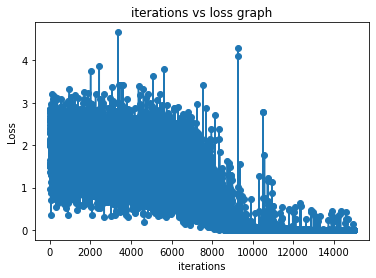

accuracy so far is  63.36363636363637  for batch size  8


In [100]:
#sample of 4323 with all images of 12401 of which 4000 for training and 323 for testing with 3 conv layers and 4 affine layers
reTrainedModel = train_and_test_my_model_with_sample(4000,8,30,0.01, None,my_data )

1  epoch - cost of the batch is :  1.769054559135437
2  epoch - cost of the batch is :  1.7031711824417115
3  epoch - cost of the batch is :  1.6278222479820252
4  epoch - cost of the batch is :  1.5661839692115784
5  epoch - cost of the batch is :  1.5348700572013856
6  epoch - cost of the batch is :  1.5136948707580566
7  epoch - cost of the batch is :  1.4879651427268983
8  epoch - cost of the batch is :  1.4515761175632478
9  epoch - cost of the batch is :  1.4074860067367554
10  epoch - cost of the batch is :  1.3278230424404145
11  epoch - cost of the batch is :  1.2041589192509652
12  epoch - cost of the batch is :  0.9980303876399994
13  epoch - cost of the batch is :  0.7389419125795365
14  epoch - cost of the batch is :  0.4072413654088974
15  epoch - cost of the batch is :  0.18648420416414738
16  epoch - cost of the batch is :  0.07071138564017601
17  epoch - cost of the batch is :  0.0646312711993698
18  epoch - cost of the batch is :  0.017076963716745375
19  epoch - cost

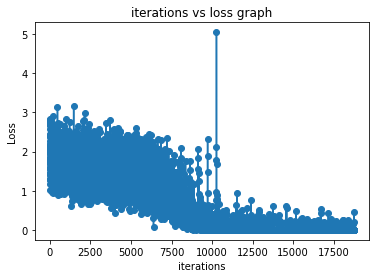

accuracy so far is  80.21657642648896  for batch size  16


In [23]:
#sample of 4000 with all images of 12401 of which 10000 for training and 323 for testing with 3 conv layers and 4 affine layers
reTrainedModel = train_and_test_my_model_with_sample(10000,16,30,0.01, None,my_data )

In [25]:
my_path = "C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/Model Submission"
torch.save(reTrainedModel.state_dict(),os.path.join(my_path,"pattern_recognition_model.pt"))

In [5]:
loaded_model = myConvNet().to(current_device)
loaded_model.load_state_dict(torch.load("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/Model Submission/pattern_recognition_model.pt"))
loaded_model.eval()

myConvNet(
  (first_conv_layer): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (max_pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (second_conv_layer): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  (third_conv_layer): Conv2d(30, 45, kernel_size=(5, 5), stride=(1, 1))
  (AL1): Linear(in_features=84270, out_features=1024, bias=True)
  (AL2): Linear(in_features=1024, out_features=128, bias=True)
  (AL3): Linear(in_features=128, out_features=17, bias=True)
)

In [28]:
type(loaded_model)

__main__.myConvNet

In [15]:
classes = {0:'OTHER',
 1:'animal',
 2:'cartoon',
 3:'chevron',
 4:'floral',
 5:'geometry',
 6:'houndstooth',
 7:'ikat',
 8:'letter_numb',
 9:'plain',
 10:'polka dot',
 11:'scales',
 12:'skull',
 13:'squares',
 14:'stars',
 15:'stripes',
 16:'tribal'}

In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [6]:
file_names = pd.read_csv("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/test/image_names.csv")

In [7]:
file_names.head()

,image,bounding_box
0,000003.jpg,"[1, 52, 467, 831]"
1,000004.jpg,"[0, 113, 467, 623]"
2,000005.jpg,"[1, 98, 467, 814]"
3,000006.jpg,"[0, 324, 466, 831]"
4,000007.jpg,"[23, 106, 430, 696]"


In [8]:
len(file_names)

2029

In [10]:
def stringToList(box):
    bbox = list()
    for x in box[1:len(bbox)-1].split(','):
        bbox.append(int(x))
    return bbox

In [57]:
def displayImage(img):
    plt.figure()
    plt.imshow(img) 
    plt.show()

In [11]:
data = file_names.sample(n=250,random_state=1)
print(len(file_names),len(data))

2029 250


In [36]:
# j = np.random.randint(0,len(file_names))
# j

In [8]:
def predictImageClothing():
    for i in range(len(file_names)):
        j = np.random.randint(0,len(file_names))
        test_image = imageWithBoundingBox(stringToList(file_names['bounding_box'][j]),file_names['image'][j])
#         test_image = image.img_to_array(test_image)
#         test_image = np.expand_dims(test_image, axis = 0)
        test_image = test_image.to(current_device)
        _,result = loaded_model(test_image)
        print(classes[np.argmax(result.detach().cpu().numpy())])
        
#         print(type(result))
        
#         np_result = result.numpy()
#         print (result)

In [6]:
def imageWithBoundingBox(bbox, no):
    im = Image.open(r"C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/test/images/"+no)
    im1 = im.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    displayImage(im1)
    transform =  transforms.ToTensor()
    tensor_image = transform(im1)
    resize = transforms.Resize([224, 224])
    return resize(tensor_image.type(torch.FloatTensor))

In [ ]:
outcomes = predictImageClothing()


In [ ]:
outcomes = predictImageClothing()

# Open CV color identification

In [7]:
bbox = [1, 52, 467, 831]

In [ ]:
def getColorName(R,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname

index=["color","color_name","hex","R","G","B"]
csv = pd.read_csv('colors.csv', names=index, header=None)
image = cv2.imread("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/test/images/000001.jpg")
cv2.imshow("image", image[bbox[0]:bbox[2]-bbox[0],bbox[1]:bbox[3]-bbox[1]])
cv2.waitKey(0)

mean_rgb = np.mean(image, axis=(0, 1))
print(getColorName(mean_rgb[0], mean_rgb[1], mean_rgb[2]))

before reading the image
after reading the image


In [8]:
def stringToList(box):
    bbox = list()
    for x in box[1:len(bbox)-1].split(','):
        bbox.append(int(x))
    return bbox

In [50]:
class myConvNet(torch.nn.Module):
    def __init__(self):
        #defining all the necessary layers in the network here
        torch.nn.Module.__init__(self)
        self.first_conv_layer = torch.nn.Conv2d(3,15,5)
        self.max_pooling_layer = torch.nn.MaxPool2d(2)#stride 1
        self.relu = torch.nn.functional.relu
        self.second_conv_layer = torch.nn.Conv2d(15,30,5)
        # self.third_conv_layer = torch.nn.Conv2d(30,45,5)
        # self.fourth_conv_layer = torch.nn.Conv2d(45,60,5)
        
        

        # the output of the cov2d layer is (batchsize, outputlayers , x , y)
        # which in our case is (batchsize x 30 x 53 x 53) for image size 244
        self.AL1 = torch.nn.Linear(30*53*53,512)
        # self.AL1 = torch.nn.Linear(60*10*10,1024) # four conv layers
        # self.AL1 = torch.nn.Linear(45*24*24,1024) # three conv layers
        self.AL2 = torch.nn.Linear(512,64)
        # self.AL3 = torch.nn.Linear(128,64)
        self.AL3 = torch.nn.Linear(64,8)
        # self.AL4 = torch.nn.Linear(64,17)
        
        
    def forward(self,x):
        
        #Conv -> Maxpooling -> ReLU -> Conv -> Dropout -> Maxpool -> ReLU
        
        
        # print("input dims",x.size())
        x = self.first_conv_layer(x)
        # print("input dims after conv1",x.size())
        x = self.max_pooling_layer(x)
        # print("input dims after maxpool1",x.size())
        x = self.relu(x)
        x = self.second_conv_layer(x)
        # print("input dims after conv2",x.size())
        # x = self.DO_layer(x)
        x = self.max_pooling_layer(x)
        # print("input dims after maxpool1",x.size())
        x = self.relu(x)
        # print("before flatten",x.size())
        
#         x = self.third_conv_layer(x)
        
#         x = self.max_pooling_layer(x)
                
#         x = self.relu(x)
        
#         x = self.fourth_conv_layer(x)
        
#         x = self.max_pooling_layer(x)
                
#         x = self.relu(x)
        
        
        # print("before flatten",x.size())
        # return 1,2
        
        
        #should flatten the input to fit the affinelayer (1-dimensional input) currently the input is 3D ( 30 x 53 x 53 )
        x = x.view(-1,30*53*53)
        

        # with 3 conv layers
        # x = x.view(-1,45*24*24)

        
        
        
        #should flatten the input to fit the affinelayer (1-dimensional input)
        #after adding more conv layers, currently the input is 3D ( 60 x 10 x 10 ) with  conv layers
        # x = x.view(-1,60*10*10)
        # print("after flatten",x.size())
        # x = torch.flatten(x)
        
        
        
        
        
        
        
        
        #AL1 -> ReLU -> Dropout -> AL2
        
        # print("input to affine layer 1",x.size())
        x = self.AL1(x)
        # print("A1",x.size())
        
        #x = torch.nn.functional.relu(x)
        x = self.relu(x)
        # print("relu",x.size())
        
        # x = self.DO_layer(x)
        
        #print("input to affine layer 2",x.size())
        x = self.AL2(x)
        # print("A2",x.size())
        
        
        x = self.relu(x) 
        
        x = self.AL3(x)
        
#         x = self.relu(x)
        
#         x = self.AL4(x)
        
        return x,torch.nn.functional.log_softmax(x, dim=1)

In [2]:
path_to_json = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/train/annos/' #replace with the directory name
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/train/image/' #replace with the directory name of images
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
df = pd.DataFrame(columns=['product_id','category_id','bounding_box','occlusion','viewpoint','zoom-in','image'])

for i in json_files:
  with open(path_to_json+""+i) as json_file:
    data = json.load(json_file)
    
    # changed category id from actual to actual-1 to fit the softmax values 0 to nclasses-1
    
    if len(data.keys())<4:
        lst=[('P'+i.split('.')[0][1:]),data['item1']['category_id'] - 1 ,str(data['item1']['bounding_box']),data['item1']['occlusion'],data['item1']['viewpoint'],data['item1']['zoom_in'],(i.split('.')[0]+'.jpg')]
        #print(lst)
        newdf = pd.DataFrame( [lst], columns=['product_id','category_id','bounding_box','occlusion','viewpoint','zoom-in', 'image'])
        df = pd.concat([df,newdf], ignore_index = True)
        # since append is deprecated, I am using concat function from pandas
        #df = df.append(pd.DataFrame( [lst], columns=['item_id','category_id','bounding_box','occlusion','viewpoint','zoom-in']), ignore_index = True)

In [4]:
df['category_id'].unique()

array([10, 1, 6, 0, 3, 11, 7, 9, 4, 2, 8, 5, 12], dtype=object)

In [12]:
df.to_csv("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/train/training_data_set.csv",index=False)

In [59]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/anuhya/1.csv' #replace with the directory name
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/anuhya/' #replace with the directory name of images

In [17]:
data = pd.read_csv(path_to_csv)

In [18]:
data.head()

,image,pattern
0,014671.jpg,plain
1,014676.jpg,printed
2,014677.jpg,printed
3,014708.jpg,stripes
4,014746.jpg,plain


In [76]:
df['image'][0]

'000003.jpg'

In [77]:
type(data)

pandas.core.frame.DataFrame

In [19]:
sel = data['image']
bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

In [20]:
bboxes = bboxes.tolist()

In [9]:
def convertImageToTensorWithBBox(image_name, bbox):
    original_image = Image.open(path_to_images+image_name)
    cropped_image = original_image.copy().crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    transform =  transforms.ToTensor()
    tensor_image = transform(cropped_image)
    
    resize = transforms.Resize([224, 224])
    return resize(tensor_image.type(torch.FloatTensor))

In [22]:
classes = {'animal':0,'cartoon':1,'letter_numb':2,'plain':3,'printed':4,'squares':5,'stripes':6,'other':7}

In [23]:
df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))

In [24]:
anuhya_fd = df_images

In [54]:
# pd_df = pd.DataFrame(df_images)

In [95]:
# data[0:10]

In [94]:
# pd_df['pattern'][0:10]

In [10]:
def displayImage(img):
    plt.figure()
    plt.imshow(img) 
    plt.show()

In [96]:
# pd_df.head()

In [22]:
# displayImage(pd_df['image'][np.random.randint(0,len(pd_df))].numpy().transpose(1, 2, 0))

In [69]:
anuhya_fd = df_images

In [26]:
anuhya_fd[0]

(tensor([[[0.8706, 0.8706, 0.8706,  ..., 0.3239, 0.3301, 0.3360],
          [0.8706, 0.8706, 0.8706,  ..., 0.3263, 0.3180, 0.3197],
          [0.8706, 0.8706, 0.8706,  ..., 0.3210, 0.3197, 0.3252],
          ...,
          [0.1943, 0.2191, 0.2083,  ..., 0.8969, 0.9026, 0.9053],
          [0.1941, 0.2156, 0.1979,  ..., 0.8975, 0.9024, 0.9053],
          [0.2034, 0.2077, 0.2198,  ..., 0.8975, 0.9032, 0.9059]],
 
         [[0.8667, 0.8667, 0.8667,  ..., 0.2751, 0.2752, 0.2811],
          [0.8667, 0.8667, 0.8667,  ..., 0.2714, 0.2631, 0.2648],
          [0.8667, 0.8667, 0.8667,  ..., 0.2653, 0.2605, 0.2586],
          ...,
          [0.1704, 0.1807, 0.1699,  ..., 0.7871, 0.7928, 0.7955],
          [0.1640, 0.1763, 0.1587,  ..., 0.7955, 0.8004, 0.8033],
          [0.1733, 0.1684, 0.1806,  ..., 0.7955, 0.8012, 0.8039]],
 
         [[0.8510, 0.8510, 0.8510,  ..., 0.3325, 0.3357, 0.3463],
          [0.8510, 0.8510, 0.8510,  ..., 0.3381, 0.3297, 0.3315],
          [0.8510, 0.8510, 0.8510,  ...,

In [ ]:
my_data[0]

(tensor([[[0.8706, 0.8706, 0.8706,  ..., 0.3239, 0.3301, 0.3360],
          [0.8706, 0.8706, 0.8706,  ..., 0.3263, 0.3180, 0.3197],
          [0.8706, 0.8706, 0.8706,  ..., 0.3210, 0.3197, 0.3252],
          ...,
          [0.1943, 0.2191, 0.2083,  ..., 0.8969, 0.9026, 0.9053],
          [0.1941, 0.2156, 0.1979,  ..., 0.8975, 0.9024, 0.9053],
          [0.2034, 0.2077, 0.2198,  ..., 0.8975, 0.9032, 0.9059]],
 
         [[0.8667, 0.8667, 0.8667,  ..., 0.2751, 0.2752, 0.2811],
          [0.8667, 0.8667, 0.8667,  ..., 0.2714, 0.2631, 0.2648],
          [0.8667, 0.8667, 0.8667,  ..., 0.2653, 0.2605, 0.2586],
          ...,
          [0.1704, 0.1807, 0.1699,  ..., 0.7871, 0.7928, 0.7955],
          [0.1640, 0.1763, 0.1587,  ..., 0.7955, 0.8004, 0.8033],
          [0.1733, 0.1684, 0.1806,  ..., 0.7955, 0.8012, 0.8039]],
 
         [[0.8510, 0.8510, 0.8510,  ..., 0.3325, 0.3357, 0.3463],
          [0.8510, 0.8510, 0.8510,  ..., 0.3381, 0.3297, 0.3315],
          [0.8510, 0.8510, 0.8510,  ...,

# Testing all the annotated dataset with SGD with just affine layers : no batch norm or no dropout used in this experiment.

1  epoch - cost of the batch is :  2.0116603699597446
2  epoch - cost of the batch is :  1.7203184393319217
3  epoch - cost of the batch is :  1.6256271519444205
4  epoch - cost of the batch is :  1.5680707869204609
5  epoch - cost of the batch is :  1.5569219101559033
6  epoch - cost of the batch is :  1.5484036071733995
7  epoch - cost of the batch is :  1.5217514525760303
8  epoch - cost of the batch is :  1.5175982957536525
9  epoch - cost of the batch is :  1.51254550028931
10  epoch - cost of the batch is :  1.4384599233215505
11  epoch - cost of the batch is :  1.4922321005301042
12  epoch - cost of the batch is :  1.4728087864138864
13  epoch - cost of the batch is :  1.4565423130989075
14  epoch - cost of the batch is :  1.4447689882733605
15  epoch - cost of the batch is :  1.4449979473244061
16  epoch - cost of the batch is :  1.3958210904489865
17  epoch - cost of the batch is :  1.407011172988198
18  epoch - cost of the batch is :  1.378510744734244
19  epoch - cost of the

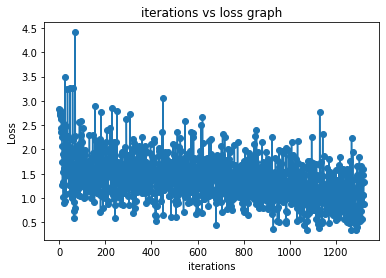

accuracy so far is  50.0  for batch size  8


In [100]:
reTrainedModel = train_and_test_my_model_with_sample(350,8,30,0.01, None,my_data)

1  epoch - cost of the batch is :  2.0078223672780124
2  epoch - cost of the batch is :  1.6320822916247628
3  epoch - cost of the batch is :  1.5855470286174254
4  epoch - cost of the batch is :  1.5470562265677885
5  epoch - cost of the batch is :  1.5774284086444161
6  epoch - cost of the batch is :  1.545156795870174
7  epoch - cost of the batch is :  1.5118364149873906
8  epoch - cost of the batch is :  1.5147593170404434
9  epoch - cost of the batch is :  1.4986063160679557
10  epoch - cost of the batch is :  1.450129277326844
11  epoch - cost of the batch is :  1.4499003453688188
12  epoch - cost of the batch is :  1.456997569311749
13  epoch - cost of the batch is :  1.3913772891868244
14  epoch - cost of the batch is :  1.4218051704493435
15  epoch - cost of the batch is :  1.3901043358174237
16  epoch - cost of the batch is :  1.3467214771292426
17  epoch - cost of the batch is :  1.3481269153681668
18  epoch - cost of the batch is :  1.285560662096197
19  epoch - cost of the

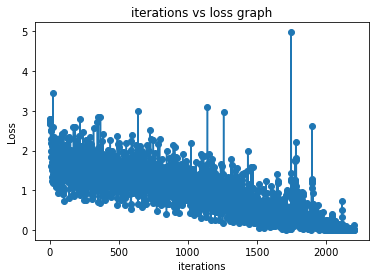

accuracy so far is  57.99999999999999  for batch size  8


In [101]:
reTrainedModel = train_and_test_my_model_with_sample(350,8,50,0.01, None,my_data)

1  epoch - cost of the batch is :  2.227561018683694
2  epoch - cost of the batch is :  1.717869444326921
3  epoch - cost of the batch is :  1.6209473745389418
4  epoch - cost of the batch is :  1.6173984083262356
5  epoch - cost of the batch is :  1.5841437036340886
6  epoch - cost of the batch is :  1.5299063650044529
7  epoch - cost of the batch is :  1.5213360705158927
8  epoch - cost of the batch is :  1.503248710523952
9  epoch - cost of the batch is :  1.5138335661454634
10  epoch - cost of the batch is :  1.4755361811681227
11  epoch - cost of the batch is :  1.4197992899201133
12  epoch - cost of the batch is :  1.4435387416319414
13  epoch - cost of the batch is :  1.4556450247764587
14  epoch - cost of the batch is :  1.4473723389885642
15  epoch - cost of the batch is :  1.4188669052991
16  epoch - cost of the batch is :  1.403463363647461
17  epoch - cost of the batch is :  1.3891518088904293
18  epoch - cost of the batch is :  1.358499838547273
19  epoch - cost of the bat

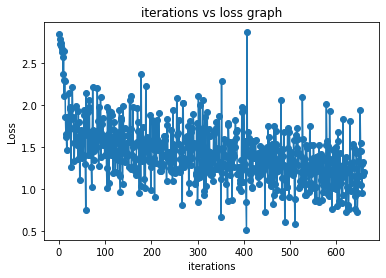

accuracy so far is  48.0  for batch size  16


In [102]:
myModel = train_and_test_my_model_with_sample(350,16,30,0.01, None,my_data)

1  epoch - cost of the batch is :  2.23776819489219
2  epoch - cost of the batch is :  1.685634114525535
3  epoch - cost of the batch is :  1.5859407403252341
4  epoch - cost of the batch is :  1.6291743300177834
5  epoch - cost of the batch is :  1.5452561649409207
6  epoch - cost of the batch is :  1.552908870306882
7  epoch - cost of the batch is :  1.5357714728875593
8  epoch - cost of the batch is :  1.5123278986323963
9  epoch - cost of the batch is :  1.4844357560981403
10  epoch - cost of the batch is :  1.4607716582038186
11  epoch - cost of the batch is :  1.4587665416977622
12  epoch - cost of the batch is :  1.4554073268716985
13  epoch - cost of the batch is :  1.4680594910274853
14  epoch - cost of the batch is :  1.4653673063624988
15  epoch - cost of the batch is :  1.4674300280484287
16  epoch - cost of the batch is :  1.4405296390706843
17  epoch - cost of the batch is :  1.3942872231656855
18  epoch - cost of the batch is :  1.417501213875684
19  epoch - cost of the 

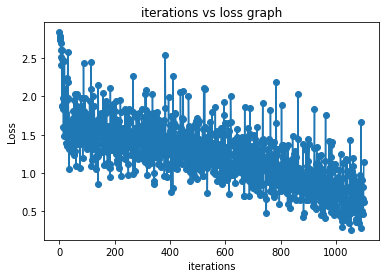

accuracy so far is  48.0  for batch size  16


In [103]:
myModel = train_and_test_my_model_with_sample(350,16,50,0.01, None,my_data)

1  epoch - cost of the batch is :  1.9987547983500091
2  epoch - cost of the batch is :  1.6851776438680561
3  epoch - cost of the batch is :  1.655284161594781
4  epoch - cost of the batch is :  1.6203425194729457
5  epoch - cost of the batch is :  1.605730713768439
6  epoch - cost of the batch is :  1.557315548712557
7  epoch - cost of the batch is :  1.5804486552422696
8  epoch - cost of the batch is :  1.557299417528239
9  epoch - cost of the batch is :  1.5451266887513073
10  epoch - cost of the batch is :  1.5104909085414626
11  epoch - cost of the batch is :  1.5365923531353474
12  epoch - cost of the batch is :  1.5274637619202787
13  epoch - cost of the batch is :  1.5080701603808186
14  epoch - cost of the batch is :  1.5021441341801123
15  epoch - cost of the batch is :  1.5071705518798395
16  epoch - cost of the batch is :  1.4847347661852837
17  epoch - cost of the batch is :  1.4554996988312765
18  epoch - cost of the batch is :  1.4173363088206812
19  epoch - cost of the

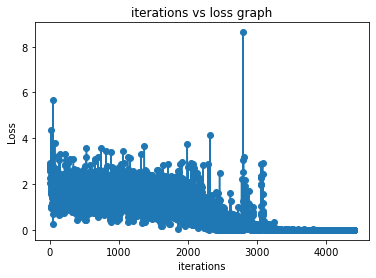

accuracy so far is  60.0  for batch size  4


In [104]:
myModel = train_and_test_my_model_with_sample(350,4,50,0.01, None,my_data)

**Data annotated by siddharth**

In [77]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/siddharth/0.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/siddharth/'

In [78]:
data = pd.read_csv(path_to_csv)
sel = data['image']
bboxes = (df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']).tolist()

In [11]:
def getWrappedData(data):
    df_images = []
    try:
        for i in range(len(data['image'])):
            df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))
    except:
        pass
    return df_images

In [80]:
data.head()

,image,pattern
0,022518.jpg,printed
1,022529.jpg,animal
2,022559.jpg,printed
3,022576.jpg,printed
4,022583.jpg,plain


In [ ]:
siddharth_data = getWrappedData(data)

1  epoch - cost of the batch is :  1.9081430543552746
2  epoch - cost of the batch is :  1.6667296717112714
3  epoch - cost of the batch is :  1.5798493037846955
4  epoch - cost of the batch is :  1.594358361580155
5  epoch - cost of the batch is :  1.5816488604653964
6  epoch - cost of the batch is :  1.564474091949788
7  epoch - cost of the batch is :  1.5181643851101398
8  epoch - cost of the batch is :  1.512106356126341
9  epoch - cost of the batch is :  1.5561769943345676
10  epoch - cost of the batch is :  1.5286048560995946
11  epoch - cost of the batch is :  1.5059058666229248
12  epoch - cost of the batch is :  1.501942857422612
13  epoch - cost of the batch is :  1.4869053743102334
14  epoch - cost of the batch is :  1.46039359474724
15  epoch - cost of the batch is :  1.402393095872619
16  epoch - cost of the batch is :  1.408393178304488
17  epoch - cost of the batch is :  1.3640305467627265
18  epoch - cost of the batch is :  1.3265365162356333
19  epoch - cost of the bat

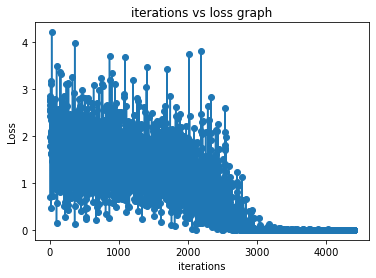

accuracy so far is  52.0  for batch size  4


In [141]:
myModel = train_and_test_my_model_with_sample(350,4,50,0.01, None,wdata)

In [85]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/shiva/3.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/shiva/'

In [86]:
data = pd.read_csv(path_to_csv)
sel = data['image']
bboxes = (df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']).tolist()

In [87]:
mixed_data = getWrappedData(data)

1  epoch - cost of the batch is :  2.0512891459194096
2  epoch - cost of the batch is :  1.8941344158215956
3  epoch - cost of the batch is :  1.854335455731912
4  epoch - cost of the batch is :  1.8203782493417913
5  epoch - cost of the batch is :  1.8027409247376702
6  epoch - cost of the batch is :  1.7802304591644893
7  epoch - cost of the batch is :  1.7832495082508435
8  epoch - cost of the batch is :  1.7646723592823201
9  epoch - cost of the batch is :  1.7232078286734493
10  epoch - cost of the batch is :  1.73827448758212
11  epoch - cost of the batch is :  1.737920356067744
12  epoch - cost of the batch is :  1.6834780831228604
13  epoch - cost of the batch is :  1.676024760712277
14  epoch - cost of the batch is :  1.6254323226484386
15  epoch - cost of the batch is :  1.6058397523381494
16  epoch - cost of the batch is :  1.5576567141847177
17  epoch - cost of the batch is :  1.5495622059838339
18  epoch - cost of the batch is :  1.4579117758707567
19  epoch - cost of the 

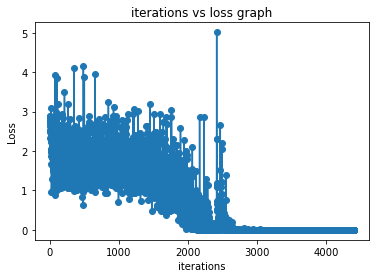

accuracy so far is  42.0  for batch size  4


myConvNet(
  (first_conv_layer): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (max_pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (second_conv_layer): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  (third_conv_layer): Conv2d(30, 45, kernel_size=(5, 5), stride=(1, 1))
  (AL1): Linear(in_features=84270, out_features=1024, bias=True)
  (AL2): Linear(in_features=1024, out_features=128, bias=True)
  (AL3): Linear(in_features=128, out_features=17, bias=True)
)

In [145]:
train_and_test_my_model_with_sample(350,4,50,0.01, None,wdata_shiva)

1  epoch - cost of the batch is :  1.8338865653673808
2  epoch - cost of the batch is :  1.7945830996831258
3  epoch - cost of the batch is :  1.7649633948008219
4  epoch - cost of the batch is :  1.7515483125050864
5  epoch - cost of the batch is :  1.7508383750915528
6  epoch - cost of the batch is :  1.75109885374705
7  epoch - cost of the batch is :  1.725895538330078
8  epoch - cost of the batch is :  1.707097094853719
9  epoch - cost of the batch is :  1.6792204904556274
10  epoch - cost of the batch is :  1.6689327931404114
11  epoch - cost of the batch is :  1.6738110733032228
12  epoch - cost of the batch is :  1.5987230777740478
13  epoch - cost of the batch is :  1.6177162392934163
14  epoch - cost of the batch is :  1.5600620412826538
15  epoch - cost of the batch is :  1.505895893573761
16  epoch - cost of the batch is :  1.4987635898590088
17  epoch - cost of the batch is :  1.4166326459248861
18  epoch - cost of the batch is :  1.3287878521283467
19  epoch - cost of the 

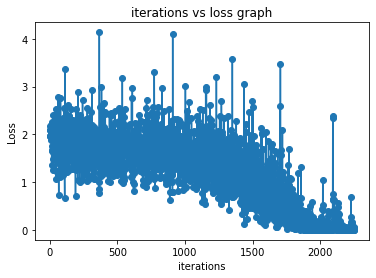

accuracy so far is  43.0  for batch size  4


myConvNet(
  (first_conv_layer): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (max_pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (second_conv_layer): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  (AL1): Linear(in_features=84270, out_features=512, bias=True)
  (AL2): Linear(in_features=512, out_features=64, bias=True)
  (AL3): Linear(in_features=64, out_features=8, bias=True)
)

In [34]:
train_and_test_my_model_with_sample(300,4,30,0.01, None,wdata_shiva)

1  epoch - cost of the batch is :  1.8364154913208701
2  epoch - cost of the batch is :  1.7726659016175703
3  epoch - cost of the batch is :  1.7577721943909472
4  epoch - cost of the batch is :  1.7632869258522987
5  epoch - cost of the batch is :  1.7666732309894129
6  epoch - cost of the batch is :  1.7318398647687652
7  epoch - cost of the batch is :  1.72297326001254
8  epoch - cost of the batch is :  1.7106826142831282
9  epoch - cost of the batch is :  1.6672917238690637
10  epoch - cost of the batch is :  1.6839545579119162
11  epoch - cost of the batch is :  1.6380034360018643
12  epoch - cost of the batch is :  1.6047151630575007
13  epoch - cost of the batch is :  1.567985731769692
14  epoch - cost of the batch is :  1.5377705415541476
15  epoch - cost of the batch is :  1.4775930805639788
16  epoch - cost of the batch is :  1.415786208754236
17  epoch - cost of the batch is :  1.3228955262086608
18  epoch - cost of the batch is :  1.2431706132536584
19  epoch - cost of the

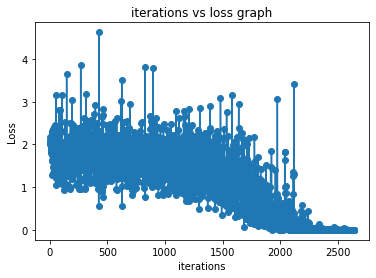

accuracy so far is  44.0  for batch size  4


In [35]:
_ = train_and_test_my_model_with_sample(350,4,30,0.01, None,wdata_shiva)

In [75]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/mixed/mixed.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/mixed/'

In [91]:
data = pd.read_csv(path_to_csv)
sel = data['image']
bboxes = (df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']).tolist()

In [92]:
wdata_mixed = getWrappedData(data)

1  epoch - cost of the batch is :  1.7281149578365413
2  epoch - cost of the batch is :  1.6702356453646312
3  epoch - cost of the batch is :  1.6604803502559662
4  epoch - cost of the batch is :  1.640734047374942
5  epoch - cost of the batch is :  1.6255582916465672
6  epoch - cost of the batch is :  1.6119882410222834
7  epoch - cost of the batch is :  1.6004762080582706
8  epoch - cost of the batch is :  1.596924284642393
9  epoch - cost of the batch is :  1.5980320823463527
10  epoch - cost of the batch is :  1.578020523894917
11  epoch - cost of the batch is :  1.5670543556863612
12  epoch - cost of the batch is :  1.5334339372136376
13  epoch - cost of the batch is :  1.5191065377809785
14  epoch - cost of the batch is :  1.50574603067203
15  epoch - cost of the batch is :  1.474380443041975
16  epoch - cost of the batch is :  1.4671405618163673
17  epoch - cost of the batch is :  1.4157470661130818
18  epoch - cost of the batch is :  1.4042549553242596
19  epoch - cost of the b

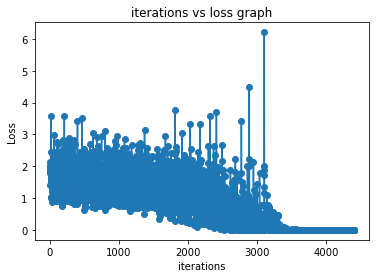

accuracy so far is  34.94117647058824  for batch size  4


myConvNet(
  (first_conv_layer): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (max_pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (second_conv_layer): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  (AL1): Linear(in_features=84270, out_features=512, bias=True)
  (AL2): Linear(in_features=512, out_features=64, bias=True)
  (AL3): Linear(in_features=64, out_features=8, bias=True)
)

In [39]:
train_and_test_my_model_with_sample(350,4,50,0.01, None,wdata_shiva)

In [43]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/aryan/2.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images/aryan/'
data = pd.read_csv(path_to_csv)
sel = data['image']

In [44]:
bboxes = (df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']).tolist()

In [47]:
len(data)

399

In [48]:
len(bboxes)

398

In [50]:
wdata_shiva = getWrappedData(data)

1  epoch - cost of the batch is :  1.7936276603828778
2  epoch - cost of the batch is :  1.728130115704103
3  epoch - cost of the batch is :  1.7052822526205669
4  epoch - cost of the batch is :  1.6741168851202184
5  epoch - cost of the batch is :  1.6732605817643078
6  epoch - cost of the batch is :  1.687475162473592
7  epoch - cost of the batch is :  1.6718216646801343
8  epoch - cost of the batch is :  1.6546186005527324
9  epoch - cost of the batch is :  1.6494157727469096
10  epoch - cost of the batch is :  1.6285199814222076
11  epoch - cost of the batch is :  1.618670984425328
12  epoch - cost of the batch is :  1.584437862715938
13  epoch - cost of the batch is :  1.5595258548855782
14  epoch - cost of the batch is :  1.5256599526513706
15  epoch - cost of the batch is :  1.490909876471216
16  epoch - cost of the batch is :  1.4409666494889692
17  epoch - cost of the batch is :  1.3843817941167138
18  epoch - cost of the batch is :  1.306612764569846
19  epoch - cost of the b

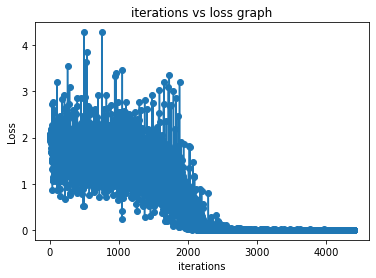

accuracy so far is  37.5  for batch size  4


In [51]:
_ = train_and_test_my_model_with_sample(350,4,50,0.01, None,wdata_shiva)

**Trying Batchnorm on the data to check the accuracy**

In [146]:
class myConvNet(torch.nn.Module):
    def __init__(self,p = 0.25):
        #defining all the necessary layers in the network here
        torch.nn.Module.__init__(self)
        self.first_conv_layer = torch.nn.Conv2d(3,15,5)
        self.first_batch_norm_layer = torch.nn.BatchNorm2d(15)
        self.max_pooling_layer = torch.nn.MaxPool2d(2)#stride 1
        self.relu = torch.nn.functional.relu
        self.second_conv_layer = torch.nn.Conv2d(15,30,5)
        self.second_batch_norm_layer = torch.nn.BatchNorm2d(30)
        self.dropout = torch.nn.Dropout(p)
        
        
        # self.third_conv_layer = torch.nn.Conv2d(30,45,5)
        # self.fourth_conv_layer = torch.nn.Conv2d(45,60,5)
        
        

        # the output of the cov2d layer is (batchsize, outputlayers , x , y)
        # which in our case is (batchsize x 30 x 53 x 53) for image size 244
        self.AL1 = torch.nn.Linear(30*53*53,512)
        # self.AL1 = torch.nn.Linear(60*10*10,1024) # four conv layers
        # self.AL1 = torch.nn.Linear(45*24*24,1024) # three conv layers
        self.AL2 = torch.nn.Linear(512,64)
        # self.AL3 = torch.nn.Linear(128,64)
        self.AL3 = torch.nn.Linear(64,8)
        # self.AL4 = torch.nn.Linear(64,17)
        
        
    def forward(self,x):
        
        debug = False
        
        if debug :
            print("input dims",x.size())
        x = self.first_conv_layer(x)
        
        if debug :
            print("input dims after conv1",x.size())
        
        x = self.max_pooling_layer(x)
        
        if debug :
            print("input dims after maxpool1",x.size())
        
        x = self.first_batch_norm_layer(x)
        
        x = self.relu(x)
        
        x = self.second_conv_layer(x)
        
        if debug :
            print("input dims after conv2",x.size())
        
        # x = self.DO_layer(x)
        
        x = self.max_pooling_layer(x)
        
        if debug :
            print("input dims after maxpool1",x.size())
        
        
        x = self.second_batch_norm_layer(x)
        
        
        x = self.relu(x)
        
        
        # print("before flatten",x.size())
        
#         x = self.third_conv_layer(x)
        
#         x = self.max_pooling_layer(x)
                
#         x = self.relu(x)
        
#         x = self.fourth_conv_layer(x)
        
#         x = self.max_pooling_layer(x)
                
#         x = self.relu(x)
        
        
        # print("before flatten",x.size())
        # return 1,2
        
        
        #should flatten the input to fit the affinelayer (1-dimensional input) currently the input is 3D ( 30 x 53 x 53 )
        x = x.view(-1,30*53*53)
        

        # with 3 conv layers
        # x = x.view(-1,45*24*24)
        
        #should flatten the input to fit the affinelayer (1-dimensional input)
        #after adding more conv layers, currently the input is 3D ( 60 x 10 x 10 ) with  conv layers
        # x = x.view(-1,60*10*10)
        # print("after flatten",x.size())
        # x = torch.flatten(x)
        
        #AL1 -> ReLU -> Dropout -> AL2
        
        # print("input to affine layer 1",x.size())
        x = self.AL1(x)
        # print("A1",x.size())
        
        #x = torch.nn.functional.relu(x)
        x = self.relu(x)
        # print("relu",x.size())
        
        # x = self.DO_layer(x)
        
        x = self.dropout(x)
        
        #print("input to affine layer 2",x.size())
        x = self.AL2(x)
        # print("A2",x.size())
        
        
        x = self.relu(x) 
        
        
        x = self.dropout(x)
        
        x = self.AL3(x)
        
#         x = self.relu(x)
        
#         x = self.AL4(x)
        
        return x,torch.nn.functional.log_softmax(x, dim=1)

In [15]:
# custom function to test the data with all the necessary steps to perform both training and testing
# for different batch sizes with different epochs and different learning rate
def train_and_test_my_model_with_sample(train_size, bsize,epochs,lr, myModel, my_data):
    train_data, test_data = torch.utils.data.random_split(my_data, [train_size, len(my_data)-train_size])
    
    train_batches = torch.utils.data.DataLoader(train_data, batch_size=bsize, shuffle=True) #shuffling data to get random samples instead of sequence
    # print(len(train_batches))
    
    test_batches = torch.utils.data.DataLoader(test_data, batch_size=bsize, shuffle=True)
    # print(len(test_batches))
    
    
    if bool(myModel)==False:
        myModel = myConvNet().to(current_device)
        
    # for x,y in train_batches:
    #     print(y)
    #     print("loop")
    
    train_my_model(epochs,train_batches,lr, myModel)
    
    plotData("iterations vs loss graph","iterations","Loss",list(range(1,len(losslst)+1)),losslst)
    
    accuracy_checker(test_batches,myModel,bsize)
    
    return myModel

In [27]:
current_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# current_device = torch.device('cpu')
current_device.type

'cuda'

1  epoch - cost of the batch is :  1.5382986583492972
2  epoch - cost of the batch is :  1.234919317743995
3  epoch - cost of the batch is :  0.908512723039497
4  epoch - cost of the batch is :  0.5654247437011112
5  epoch - cost of the batch is :  0.2624590723690661
6  epoch - cost of the batch is :  0.12412260178561238
7  epoch - cost of the batch is :  0.04049182818694548
8  epoch - cost of the batch is :  0.02533115392593159
9  epoch - cost of the batch is :  0.01581680480740033
10  epoch - cost of the batch is :  0.00966553496651944
11  epoch - cost of the batch is :  0.009922125847713853
12  epoch - cost of the batch is :  0.007894915279889987
13  epoch - cost of the batch is :  0.007642680416624485
14  epoch - cost of the batch is :  0.005704909081528472
15  epoch - cost of the batch is :  0.004622572112235834
16  epoch - cost of the batch is :  0.005447343999879773
17  epoch - cost of the batch is :  0.003935265940857458
18  epoch - cost of the batch is :  0.0056957218383269555

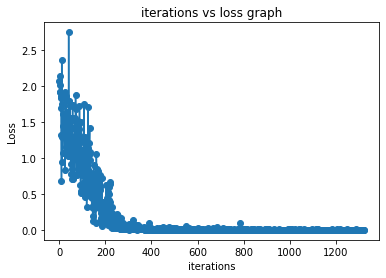

accuracy so far is  57.99999999999999  for batch size  8


In [28]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(350,8,30,0.01, None,my_data)

**With batchnorm, the accuracy increased a little from 50% to 58%, but still its not up to the acceptance level which we belive is 70-80%**

1  epoch - cost of the batch is :  1.582693679088896
2  epoch - cost of the batch is :  1.30719740527936
3  epoch - cost of the batch is :  0.924940662458539
4  epoch - cost of the batch is :  0.5488586801485243
5  epoch - cost of the batch is :  0.37968665570952
6  epoch - cost of the batch is :  0.05159159299629126
7  epoch - cost of the batch is :  0.04115399330972154
8  epoch - cost of the batch is :  0.012305973761778494
9  epoch - cost of the batch is :  0.005996603783800806
10  epoch - cost of the batch is :  0.005464076209632781
11  epoch - cost of the batch is :  0.014736965291686747
12  epoch - cost of the batch is :  0.007218205780728485
13  epoch - cost of the batch is :  0.0031431542186779056
14  epoch - cost of the batch is :  0.003293623422368083
15  epoch - cost of the batch is :  0.0023221202294404397
16  epoch - cost of the batch is :  0.0014430108508039748
17  epoch - cost of the batch is :  0.0017372303467792253
18  epoch - cost of the batch is :  0.0013424459953832

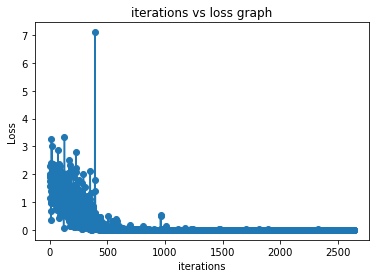

accuracy so far is  60.0  for batch size  4


In [29]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(350,4,30,0.01, None,my_data)

**with batchnorm, the accuracy got increased further when different batch size**

1  epoch - cost of the batch is :  1.602791545743292
2  epoch - cost of the batch is :  1.394278159873052
3  epoch - cost of the batch is :  1.1961697759953411
4  epoch - cost of the batch is :  0.7968406345356595
5  epoch - cost of the batch is :  0.39554803467101673
6  epoch - cost of the batch is :  0.18330294607783965
7  epoch - cost of the batch is :  0.08682841622926803
8  epoch - cost of the batch is :  0.09567037507209038
9  epoch - cost of the batch is :  0.09320065704543429
10  epoch - cost of the batch is :  0.016979457475827076
11  epoch - cost of the batch is :  0.00541577123360846
12  epoch - cost of the batch is :  0.004216041762819342
13  epoch - cost of the batch is :  0.00272549817269795
14  epoch - cost of the batch is :  0.007396206259190049
15  epoch - cost of the batch is :  0.020836679683105267


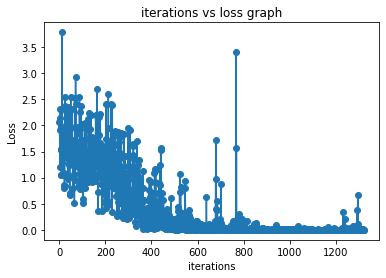

accuracy so far is  70.0  for batch size  4


In [30]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(350,4,15,0.01, None,my_data)

**The model performed excellently this time, however we feel this just has to be fluke. What we believe would happen is that the images that were in the test data might belong to a category which could be predicted well**

1  epoch - cost of the batch is :  1.5987517027692362
2  epoch - cost of the batch is :  1.3259674185378985
3  epoch - cost of the batch is :  1.0471551765433766
4  epoch - cost of the batch is :  0.6529273704456334
5  epoch - cost of the batch is :  0.35775599494280125
6  epoch - cost of the batch is :  0.1192705859192012
7  epoch - cost of the batch is :  0.021880472270409387
8  epoch - cost of the batch is :  0.009912793631056875
9  epoch - cost of the batch is :  0.006091778860288535
10  epoch - cost of the batch is :  0.005122931000063214
11  epoch - cost of the batch is :  0.004810785514078733
12  epoch - cost of the batch is :  0.003047246268827373
13  epoch - cost of the batch is :  0.005128984487865554
14  epoch - cost of the batch is :  0.0023215380004909425
15  epoch - cost of the batch is :  0.001571391955001838


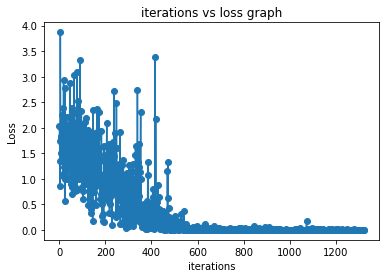

accuracy so far is  64.0  for batch size  4


In [31]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(350,4,15,0.01, None,my_data)

In [36]:
wdata = getWrappedData(data)

**mixed with  all 4 annotated data datasets**

1  epoch - cost of the batch is :  1.7322857244448229
2  epoch - cost of the batch is :  1.6503409465605563
3  epoch - cost of the batch is :  1.512862772426822
4  epoch - cost of the batch is :  1.3653848028995774
5  epoch - cost of the batch is :  1.17444022372365
6  epoch - cost of the batch is :  0.8890676847235723
7  epoch - cost of the batch is :  0.48900346614589746
8  epoch - cost of the batch is :  0.25888974325921893
9  epoch - cost of the batch is :  0.20076908612496813
10  epoch - cost of the batch is :  0.16296995351860294
11  epoch - cost of the batch is :  0.12966019159218625
12  epoch - cost of the batch is :  0.12208935744076205
13  epoch - cost of the batch is :  0.07465201238565813
14  epoch - cost of the batch is :  0.06082446449136114
15  epoch - cost of the batch is :  0.07852834731213741


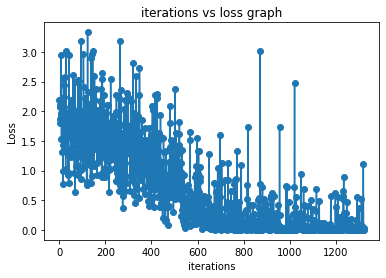

accuracy so far is  34.53525641025641  for batch size  4


In [37]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(350,4,15,0.01, None,wdata)

1  epoch - cost of the batch is :  1.6375938247550617
2  epoch - cost of the batch is :  1.4266416389833798
3  epoch - cost of the batch is :  1.302208343690092
4  epoch - cost of the batch is :  1.0714350857517936
5  epoch - cost of the batch is :  0.791717166589065
6  epoch - cost of the batch is :  0.4795316373082725
7  epoch - cost of the batch is :  0.2332308991727504
8  epoch - cost of the batch is :  0.15336181118618697
9  epoch - cost of the batch is :  0.14153298564170572
10  epoch - cost of the batch is :  0.08972482311285356
11  epoch - cost of the batch is :  0.0821647251564586
12  epoch - cost of the batch is :  0.06959359276648187
13  epoch - cost of the batch is :  0.05273488756078719
14  epoch - cost of the batch is :  0.05863603208722039
15  epoch - cost of the batch is :  0.05664839699271728
16  epoch - cost of the batch is :  0.05040406710626981
17  epoch - cost of the batch is :  0.04734644658244427
18  epoch - cost of the batch is :  0.05158523577318357
19  epoch -

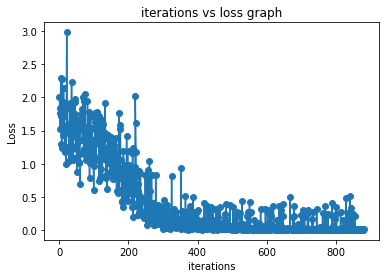

accuracy so far is  38.46153846153847  for batch size  8


In [38]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(350,8,20,0.01, None,wdata)

**With dropout layer added**

1  epoch - cost of the batch is :  1.7416332824663683
2  epoch - cost of the batch is :  1.5982076661153273
3  epoch - cost of the batch is :  1.4953761073676022
4  epoch - cost of the batch is :  1.3661545596339486
5  epoch - cost of the batch is :  1.200983846729452
6  epoch - cost of the batch is :  0.9297410886396061
7  epoch - cost of the batch is :  0.7280917357314717
8  epoch - cost of the batch is :  0.61116194894368
9  epoch - cost of the batch is :  0.4530030111358924
10  epoch - cost of the batch is :  0.25442386003719136
11  epoch - cost of the batch is :  0.2515847480601885
12  epoch - cost of the batch is :  0.1238939934621819
13  epoch - cost of the batch is :  0.1100621639105322
14  epoch - cost of the batch is :  0.08534146435770461
15  epoch - cost of the batch is :  0.06801705288870091
16  epoch - cost of the batch is :  0.06268000593197277
17  epoch - cost of the batch is :  0.04657167213471522
18  epoch - cost of the batch is :  0.05984438306900715
19  epoch - cost

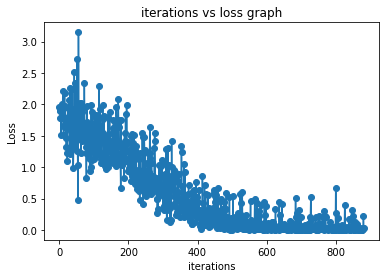

accuracy so far is  33.97435897435898  for batch size  8


In [43]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(350,8,20,0.01, None,wdata)

1  epoch - cost of the batch is :  1.7055765666280474
2  epoch - cost of the batch is :  1.6304245383398874
3  epoch - cost of the batch is :  1.5710413684163775
4  epoch - cost of the batch is :  1.515109853403909
5  epoch - cost of the batch is :  1.416826388154711
6  epoch - cost of the batch is :  1.2407835837772914
7  epoch - cost of the batch is :  0.9788228052003043
8  epoch - cost of the batch is :  0.6961216648135866
9  epoch - cost of the batch is :  0.4746340110046523
10  epoch - cost of the batch is :  0.3498375023049968
11  epoch - cost of the batch is :  0.193131900621312
12  epoch - cost of the batch is :  0.18487112846092454
13  epoch - cost of the batch is :  0.19118827990655388
14  epoch - cost of the batch is :  0.1023889746541889
15  epoch - cost of the batch is :  0.06738082864267718
16  epoch - cost of the batch is :  0.05853188433123121
17  epoch - cost of the batch is :  0.10675209129827895
18  epoch - cost of the batch is :  0.10842967619487484
19  epoch - cost

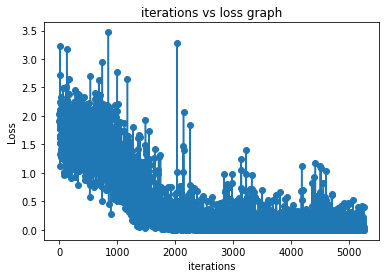

accuracy so far is  36.36363636363637  for batch size  8


In [45]:
# training and testing on anuhya data with batch norm enabled
_ = train_and_test_my_model_with_sample(1400,8,30,0.01, None,wdata)

1  epoch - cost of the batch is :  1.673622567402689
2  epoch - cost of the batch is :  1.4065031534747074
3  epoch - cost of the batch is :  1.27692312472745
4  epoch - cost of the batch is :  1.138411303099833
5  epoch - cost of the batch is :  0.9554086060900437
6  epoch - cost of the batch is :  0.7752690805416358
7  epoch - cost of the batch is :  0.48532151724947126
8  epoch - cost of the batch is :  0.38108025657895367
9  epoch - cost of the batch is :  0.1671338401930897
10  epoch - cost of the batch is :  0.15022855727492193
11  epoch - cost of the batch is :  0.1551936896468856
12  epoch - cost of the batch is :  0.052300738247332015
13  epoch - cost of the batch is :  0.03714798786064708
14  epoch - cost of the batch is :  0.03881726161834147
15  epoch - cost of the batch is :  0.021100761736498067
16  epoch - cost of the batch is :  0.03951333705060135
17  epoch - cost of the batch is :  0.029031708706354135
18  epoch - cost of the batch is :  0.013981065649300274
19  epoch

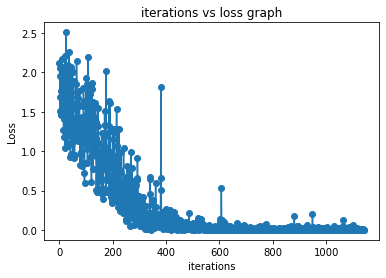

accuracy so far is  53.0  for batch size  8


In [58]:
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,anuhya_ds)

**because the testing samples were more and training samples were less, the accuracy went down even with dropout layer added to the network**

1  epoch - cost of the batch is :  1.6416312632235615
2  epoch - cost of the batch is :  1.4559528759934686
3  epoch - cost of the batch is :  1.316540391607718
4  epoch - cost of the batch is :  1.1183550310405819
5  epoch - cost of the batch is :  0.9207745587283914
6  epoch - cost of the batch is :  0.648704775355079
7  epoch - cost of the batch is :  0.4370684434067119
8  epoch - cost of the batch is :  0.26288344291970134
9  epoch - cost of the batch is :  0.12941991872238842
10  epoch - cost of the batch is :  0.10838071305558762
11  epoch - cost of the batch is :  0.08554184737361291
12  epoch - cost of the batch is :  0.041755072509245525
13  epoch - cost of the batch is :  0.03743777553476817
14  epoch - cost of the batch is :  0.017037163411838595
15  epoch - cost of the batch is :  0.014479941468876363
16  epoch - cost of the batch is :  0.012708073549385352
17  epoch - cost of the batch is :  0.017742762082145255
18  epoch - cost of the batch is :  0.008574581742075017
19  

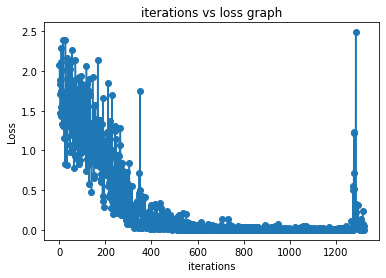

accuracy so far is  62.0  for batch size  8


In [59]:
_ = train_and_test_my_model_with_sample(350,8,30,0.01, None,anuhya_ds)

1  epoch - cost of the batch is :  1.681208337572488
2  epoch - cost of the batch is :  1.5287663476033644
3  epoch - cost of the batch is :  1.3122605400329286
4  epoch - cost of the batch is :  1.2186101588674567
5  epoch - cost of the batch is :  0.9626280446113511
6  epoch - cost of the batch is :  0.6912547225471247
7  epoch - cost of the batch is :  0.3465956454271112
8  epoch - cost of the batch is :  0.19031842157280401
9  epoch - cost of the batch is :  0.1110663908158048
10  epoch - cost of the batch is :  0.1016358109855818
11  epoch - cost of the batch is :  0.15895443942959406
12  epoch - cost of the batch is :  0.029349943448902526
13  epoch - cost of the batch is :  0.023522286614272823
14  epoch - cost of the batch is :  0.024826176876269365
15  epoch - cost of the batch is :  0.03971762790308472
16  epoch - cost of the batch is :  0.008076354409868454
17  epoch - cost of the batch is :  0.03150862456360218
18  epoch - cost of the batch is :  0.010912637596154634
19  ep

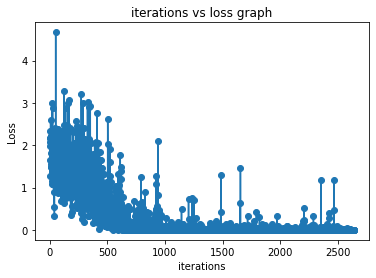

accuracy so far is  64.0  for batch size  4


In [60]:
_ = train_and_test_my_model_with_sample(350,4,30,0.01, None,anuhya_ds)

# Trying the same model with ADAM optimizer

In [159]:
itrlst = list()
losslst = list()

# functioni to train the convolutional neural nets with the sample images
def train_my_model(epochs,train_batches,lr, myModel):
    global gradients
    gradients=0
    
    # crossEntropyLoss = torch.nn.CrossEntropyLoss(reduction='none') # accuracy is not improving
    crossEntropyLoss = torch.nn.CrossEntropyLoss()
    # SGD = torch.optim.SGD(myModel.parameters(), lr)
    ADAM = torch.optim.Adam(myModel.parameters(), lr)

    global itrlst
    itrlst.clear()
    global losslst
    losslst.clear()

    n = len(train_batches)
    # print(n)
    #for each_epoch in range(epochs):
    i=1
    for each_epoch in range(epochs):
        current_loss = []
        current_loss.clear()
        for itr,(x_true, y_true) in enumerate(train_batches):
            # print(x_true.size())
            # print(type(x_true))
            # print(y_true.size())
            # print(type(y_true))
            x_true = x_true.to(current_device)
            y_true = y_true.to(current_device)
            
            # x_true.requires_grad = True

            y_pred,y_softmax = myModel(x_true)
            
            # print(x_true.size())
            # print(y_true.size())
            # print(y_pred.size())
            # print(y_softmax.size())
            
            # print(y_true)
            ce_loss = crossEntropyLoss(y_pred,y_true)
            
            # SGD.zero_grad()
            ADAM.zero_grad()
            ce_loss.sum().backward()
            # SGD.step()
            ADAM.step()
            
            itrlst.append(i)
            i=i+1
            current_loss.append(ce_loss.item())
            # print("a batch is completed")
            # break
            
        print(each_epoch + 1 , " epoch - cost of the batch is : ", sum(current_loss)/len(current_loss))
        losslst = losslst+current_loss

1  epoch - cost of the batch is :  19.913953947411343
2  epoch - cost of the batch is :  1.6871883963996714
3  epoch - cost of the batch is :  1.5397947268052534
4  epoch - cost of the batch is :  1.5000651289116254
5  epoch - cost of the batch is :  1.4913544072346254
6  epoch - cost of the batch is :  1.482126815075224
7  epoch - cost of the batch is :  1.4840248328718273
8  epoch - cost of the batch is :  1.627371926199306
9  epoch - cost of the batch is :  1.5216239426623692
10  epoch - cost of the batch is :  1.4982653456655415
11  epoch - cost of the batch is :  1.4978343966332348
12  epoch - cost of the batch is :  1.4876209036870436
13  epoch - cost of the batch is :  1.4802346669814803
14  epoch - cost of the batch is :  1.4842453090982004
15  epoch - cost of the batch is :  1.4828774217854848
16  epoch - cost of the batch is :  1.4825034893371842
17  epoch - cost of the batch is :  1.4811109974980354
18  epoch - cost of the batch is :  1.4799116639928385
19  epoch - cost of t

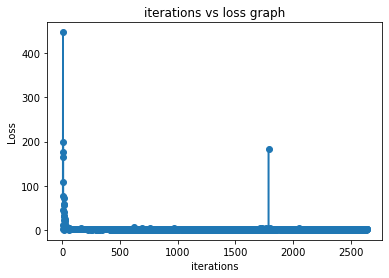

accuracy so far is  52.0  for batch size  4


In [67]:
_ = train_and_test_my_model_with_sample(350,4,30,0.01, None,anuhya_ds)

1  epoch - cost of the batch is :  362.76919615471905
2  epoch - cost of the batch is :  1.5287306247787043
3  epoch - cost of the batch is :  1.6297745108604431
4  epoch - cost of the batch is :  1.5037843429229476
5  epoch - cost of the batch is :  1.5094663324681195
6  epoch - cost of the batch is :  1.501859265294942
7  epoch - cost of the batch is :  1.4970072324980388
8  epoch - cost of the batch is :  1.5143575627695431
9  epoch - cost of the batch is :  2.0973485850475053
10  epoch - cost of the batch is :  1.7270967614921657
11  epoch - cost of the batch is :  1.5304217623038725
12  epoch - cost of the batch is :  1.498379964720119
13  epoch - cost of the batch is :  1.5063743835145778
14  epoch - cost of the batch is :  1.4983198317614468
15  epoch - cost of the batch is :  1.4983010637489231
16  epoch - cost of the batch is :  1.4949692155827174
17  epoch - cost of the batch is :  1.5037875629284165
18  epoch - cost of the batch is :  1.4923456893725828
19  epoch - cost of t

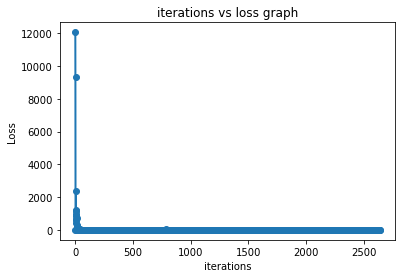

accuracy so far is  57.99999999999999  for batch size  4


In [68]:
_ = train_and_test_my_model_with_sample(350,4,30,0.05, None,anuhya_ds)

1  epoch - cost of the batch is :  205.82457886771724
2  epoch - cost of the batch is :  1.8574795038862661
3  epoch - cost of the batch is :  2.1190496987917204
4  epoch - cost of the batch is :  1.5694741674444892
5  epoch - cost of the batch is :  1.8820061141794378
6  epoch - cost of the batch is :  2.860782366584648
7  epoch - cost of the batch is :  1.5148496011441404
8  epoch - cost of the batch is :  1.5084208913824775
9  epoch - cost of the batch is :  8.48842803388834
10  epoch - cost of the batch is :  1.5496721308339725
11  epoch - cost of the batch is :  1.5190923620354047
12  epoch - cost of the batch is :  1.523965228687633
13  epoch - cost of the batch is :  3.870280531319705
14  epoch - cost of the batch is :  1.5078534775159576
15  epoch - cost of the batch is :  1.6581454202532768
16  epoch - cost of the batch is :  1.5086238851601428
17  epoch - cost of the batch is :  1.7978499640117993
18  epoch - cost of the batch is :  1.512317424470728
19  epoch - cost of the b

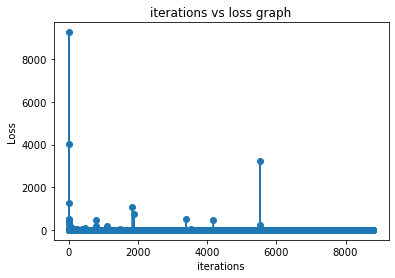

accuracy so far is  56.00000000000001  for batch size  4


In [69]:
_ = train_and_test_my_model_with_sample(350,4,100,0.05, None,anuhya_ds)

1  epoch - cost of the batch is :  345.1631909343931
2  epoch - cost of the batch is :  1.5067574832174513
3  epoch - cost of the batch is :  1.5107518328560723
4  epoch - cost of the batch is :  1.5067919625176325
5  epoch - cost of the batch is :  1.508044844865799
6  epoch - cost of the batch is :  1.5068680213557348
7  epoch - cost of the batch is :  1.7592455897066328
8  epoch - cost of the batch is :  1.5055787689156002
9  epoch - cost of the batch is :  1.5390818874041239
10  epoch - cost of the batch is :  2.209930327203539


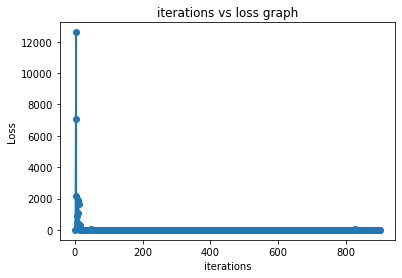

accuracy so far is  57.49999999999999  for batch size  4


In [72]:
_ = train_and_test_my_model_with_sample(360,4,10,0.05, None,anuhya_ds)

1  epoch - cost of the batch is :  629.5759739498297
2  epoch - cost of the batch is :  4.669265119234721
3  epoch - cost of the batch is :  2.1423640641901227
4  epoch - cost of the batch is :  1.4880984836154514
5  epoch - cost of the batch is :  1.6238887621296776


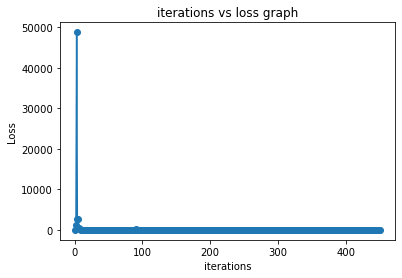

accuracy so far is  67.5  for batch size  4


In [74]:
_ = train_and_test_my_model_with_sample(360,4,5,0.05, None,anuhya_ds)

**A mix of Siddharth and Anuhya data**

1  epoch - cost of the batch is :  19.74654953347312
2  epoch - cost of the batch is :  1.9417378187179566
3  epoch - cost of the batch is :  1.843282209502326
4  epoch - cost of the batch is :  1.8701445433828565
5  epoch - cost of the batch is :  1.7548148062494067
6  epoch - cost of the batch is :  1.719647392961714
7  epoch - cost of the batch is :  1.7118702517615425
8  epoch - cost of the batch is :  1.711785372098287
9  epoch - cost of the batch is :  1.7099142869313557
10  epoch - cost of the batch is :  1.717907300260332
11  epoch - cost of the batch is :  1.714223563671112
12  epoch - cost of the batch is :  1.7100512001249526
13  epoch - cost of the batch is :  1.7110054863823785
14  epoch - cost of the batch is :  1.71101893319024
15  epoch - cost of the batch is :  1.986905562877655
16  epoch - cost of the batch is :  1.7190205732981363
17  epoch - cost of the batch is :  1.7105023476812575
18  epoch - cost of the batch is :  1.7108481778038873
19  epoch - cost of the batc

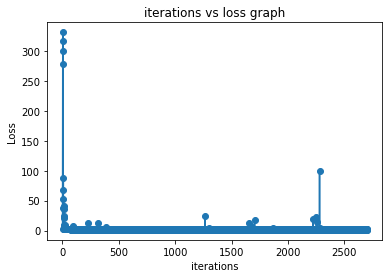

accuracy so far is  27.500000000000004  for batch size  4


In [95]:
_ = train_and_test_my_model_with_sample(360,4,30,0.01, None,mixed_data)

1  epoch - cost of the batch is :  39.2134736054822
2  epoch - cost of the batch is :  1.9533493424716748
3  epoch - cost of the batch is :  1.8594604165930497
4  epoch - cost of the batch is :  1.7836442307422036
5  epoch - cost of the batch is :  1.789101823380119
6  epoch - cost of the batch is :  1.721950546691292
7  epoch - cost of the batch is :  1.9195669638483148
8  epoch - cost of the batch is :  1.7230769113490456
9  epoch - cost of the batch is :  1.7338461844544661
10  epoch - cost of the batch is :  1.7522183531209041
11  epoch - cost of the batch is :  1.7172920107841492
12  epoch - cost of the batch is :  1.7197691798210144
13  epoch - cost of the batch is :  2.106161261859693
14  epoch - cost of the batch is :  1.745135746504131
15  epoch - cost of the batch is :  1.7197163638315702
16  epoch - cost of the batch is :  1.7350919027077525
17  epoch - cost of the batch is :  2.1210399521024605
18  epoch - cost of the batch is :  1.850241692442643
19  epoch - cost of the ba

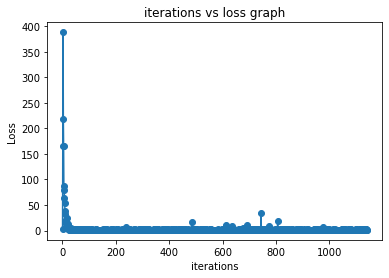

accuracy so far is  34.0  for batch size  8


In [90]:
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,mixed_data)

**A mix of Siddharth and Shiva data**

1  epoch - cost of the batch is :  30.891839265823364
2  epoch - cost of the batch is :  1.9640132502505654
3  epoch - cost of the batch is :  1.8572266760625338
4  epoch - cost of the batch is :  1.7828261946377002
5  epoch - cost of the batch is :  1.8267670179668225
6  epoch - cost of the batch is :  1.7268038235212628
7  epoch - cost of the batch is :  1.7212120514166982
8  epoch - cost of the batch is :  1.7219049020817405
9  epoch - cost of the batch is :  1.7092465193648088
10  epoch - cost of the batch is :  1.7175986578589992
11  epoch - cost of the batch is :  1.714842727309779
12  epoch - cost of the batch is :  1.7167962695422925
13  epoch - cost of the batch is :  1.7117118082548444
14  epoch - cost of the batch is :  1.7059577954442877
15  epoch - cost of the batch is :  1.71395249429502
16  epoch - cost of the batch is :  1.7146007199036448
17  epoch - cost of the batch is :  1.7068825803304974
18  epoch - cost of the batch is :  1.7178694888165122
19  epoch - cost of th

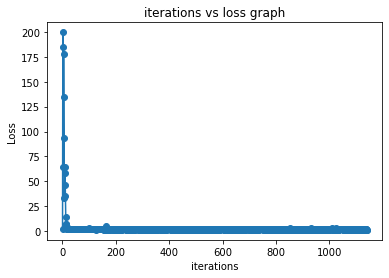

accuracy so far is  28.999999999999996  for batch size  8


In [93]:
#Shiva and Siddharth Data Mix
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,wdata_mixed)

1  epoch - cost of the batch is :  63.390491153064524
2  epoch - cost of the batch is :  1.958361195890527
3  epoch - cost of the batch is :  1.99688174222645
4  epoch - cost of the batch is :  1.7593464004366022
5  epoch - cost of the batch is :  1.724611144316824
6  epoch - cost of the batch is :  1.7077597254200985
7  epoch - cost of the batch is :  1.696432417944858
8  epoch - cost of the batch is :  1.6944388527619212
9  epoch - cost of the batch is :  1.6847817270379317
10  epoch - cost of the batch is :  1.6878613233566284
11  epoch - cost of the batch is :  1.6823147347098903
12  epoch - cost of the batch is :  1.6982207298278809
13  epoch - cost of the batch is :  1.6860794613235874
14  epoch - cost of the batch is :  1.6886783304967379
15  epoch - cost of the batch is :  1.6819565892219543
16  epoch - cost of the batch is :  1.690031820221951
17  epoch - cost of the batch is :  1.6867414116859436
18  epoch - cost of the batch is :  1.6775225589149876
19  epoch - cost of the b

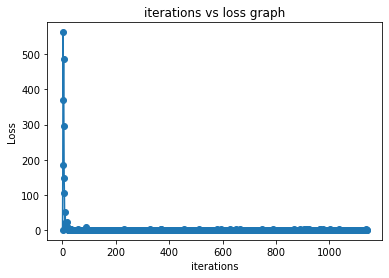

accuracy so far is  25.0  for batch size  8


In [94]:
#Shiva and Siddharth Data Mix
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,wdata_mixed)

**A mix of Shiva and Anuhya data**

In [96]:
data = pd.read_csv(path_to_csv)
sel = data['image']
bboxes = (df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']).tolist()
mixed_data = getWrappedData(data)

1  epoch - cost of the batch is :  32.931960918401415
2  epoch - cost of the batch is :  2.0197682255192806
3  epoch - cost of the batch is :  1.8796269517195852
4  epoch - cost of the batch is :  1.7714712964861017
5  epoch - cost of the batch is :  1.7446511293712414
6  epoch - cost of the batch is :  1.7351047490772449
7  epoch - cost of the batch is :  1.725197239925987
8  epoch - cost of the batch is :  1.725162829223432
9  epoch - cost of the batch is :  1.7253942050431903
10  epoch - cost of the batch is :  1.7253050427687795
11  epoch - cost of the batch is :  1.7228552354009528
12  epoch - cost of the batch is :  1.7266327111344588
13  epoch - cost of the batch is :  1.7218062187495984
14  epoch - cost of the batch is :  1.719757798470949
15  epoch - cost of the batch is :  1.7245300004356785
16  epoch - cost of the batch is :  1.7216334813519527
17  epoch - cost of the batch is :  1.7428643640718962
18  epoch - cost of the batch is :  1.7297113286821466
19  epoch - cost of th

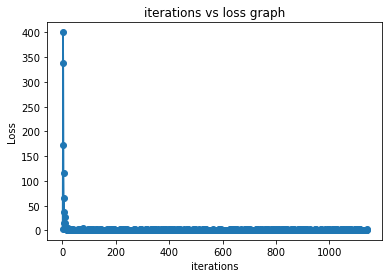

accuracy so far is  32.0  for batch size  8


In [97]:
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,mixed_data)

1  epoch - cost of the batch is :  36.67005559444428
2  epoch - cost of the batch is :  1.895622690518697
3  epoch - cost of the batch is :  1.9318434588114421
4  epoch - cost of the batch is :  1.7243000253041585
5  epoch - cost of the batch is :  1.7129533799489338
6  epoch - cost of the batch is :  1.7077263116836547
7  epoch - cost of the batch is :  1.705419815381368
8  epoch - cost of the batch is :  1.7046858501434325
9  epoch - cost of the batch is :  1.7081374756495158
10  epoch - cost of the batch is :  1.7032305177052816
11  epoch - cost of the batch is :  1.704237093925476
12  epoch - cost of the batch is :  1.7028442049026489
13  epoch - cost of the batch is :  1.7039651203155517
14  epoch - cost of the batch is :  3.0409086100260416
15  epoch - cost of the batch is :  1.7118536392847696
16  epoch - cost of the batch is :  1.7448979218800862
17  epoch - cost of the batch is :  1.8905125045776368
18  epoch - cost of the batch is :  1.7031687466303507
19  epoch - cost of the

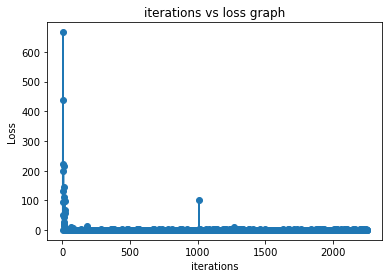

accuracy so far is  31.0  for batch size  4


In [98]:
_ = train_and_test_my_model_with_sample(300,4,30,0.01, None,mixed_data)

1  epoch - cost of the batch is :  31.95372274054421
2  epoch - cost of the batch is :  1.9306775622897678
3  epoch - cost of the batch is :  1.742954949537913
4  epoch - cost of the batch is :  1.71767867008845
5  epoch - cost of the batch is :  1.7380133006307814
6  epoch - cost of the batch is :  1.7094606624709234
7  epoch - cost of the batch is :  1.7076367682880826
8  epoch - cost of the batch is :  1.7069164885414971
9  epoch - cost of the batch is :  1.7063517967859905
10  epoch - cost of the batch is :  1.7138856106334261
11  epoch - cost of the batch is :  1.7065198924806384
12  epoch - cost of the batch is :  1.7057259162267049
13  epoch - cost of the batch is :  1.7062176704406737
14  epoch - cost of the batch is :  1.706762692001131
15  epoch - cost of the batch is :  1.707560862435235
16  epoch - cost of the batch is :  1.7068841152720982
17  epoch - cost of the batch is :  1.7062757359610663
18  epoch - cost of the batch is :  1.7088622940911187
19  epoch - cost of the b

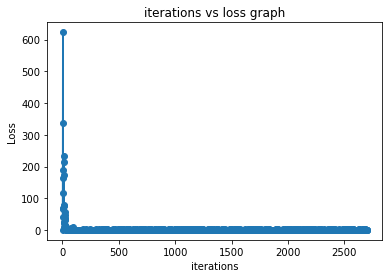

accuracy so far is  30.0  for batch size  4


In [99]:
_ = train_and_test_my_model_with_sample(360,4,30,0.01, None,mixed_data)

1  epoch - cost of the batch is :  18.619799588786233
2  epoch - cost of the batch is :  2.178996323214637
3  epoch - cost of the batch is :  1.7704842885335286
4  epoch - cost of the batch is :  1.7164610505104065
5  epoch - cost of the batch is :  1.744027774863773
6  epoch - cost of the batch is :  1.7051195157898797
7  epoch - cost of the batch is :  1.7044255521562364
8  epoch - cost of the batch is :  1.7035022179285686
9  epoch - cost of the batch is :  1.7039703170458476
10  epoch - cost of the batch is :  1.7045786592695449


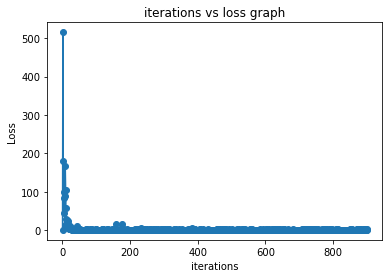

accuracy so far is  30.0  for batch size  4


In [100]:
_ = train_and_test_my_model_with_sample(360,4,10,0.01, None,mixed_data)

# checking on anuhya's revised annotated dataset

360
1  epoch - cost of the batch is :  1.651787549422847
2  epoch - cost of the batch is :  1.5609879434108733
3  epoch - cost of the batch is :  1.4968296276198494
4  epoch - cost of the batch is :  1.4945449729760487
5  epoch - cost of the batch is :  1.4482499592834048
6  epoch - cost of the batch is :  1.4521474175983005
7  epoch - cost of the batch is :  1.4180638521909714
8  epoch - cost of the batch is :  1.424337649014261
9  epoch - cost of the batch is :  1.4033418632215924
10  epoch - cost of the batch is :  1.3951165616512298


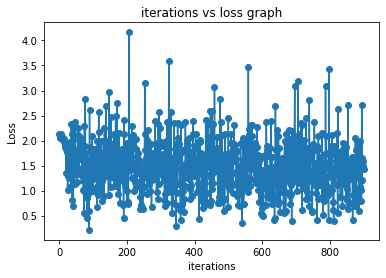

accuracy so far is  37.5  for batch size  4


In [85]:
_ = train_and_test_my_model_with_sample(360,4,10,0.01, None,anuhya_fd)

**with sgd, we got 37.5 for 10 epoches**

360
1  epoch - cost of the batch is :  3.4739419129159717
2  epoch - cost of the batch is :  1.4871049556467268
3  epoch - cost of the batch is :  1.4907005661063724
4  epoch - cost of the batch is :  1.4869007686773936
5  epoch - cost of the batch is :  1.4882690462801191
6  epoch - cost of the batch is :  1.476964967118369
7  epoch - cost of the batch is :  1.4809485342767503
8  epoch - cost of the batch is :  1.4782986203829447
9  epoch - cost of the batch is :  1.4832628965377808
10  epoch - cost of the batch is :  1.4798974434534709


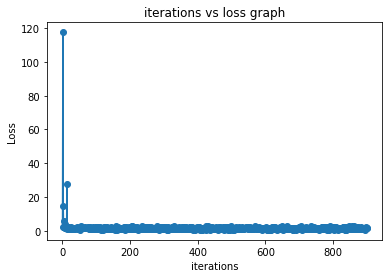

accuracy so far is  55.00000000000001  for batch size  4


In [87]:
_ = train_and_test_my_model_with_sample(360,4,10,0.01, None,anuhya_fd)

360
1  epoch - cost of the batch is :  1.6737320522467296
2  epoch - cost of the batch is :  1.5795147796471913
3  epoch - cost of the batch is :  1.5584362321429783
4  epoch - cost of the batch is :  1.5611292637056775
5  epoch - cost of the batch is :  1.55192615058687
6  epoch - cost of the batch is :  1.527057878838645
7  epoch - cost of the batch is :  1.5060105494327016
8  epoch - cost of the batch is :  1.480494541592068
9  epoch - cost of the batch is :  1.4752179238531324
10  epoch - cost of the batch is :  1.4520383722252317
11  epoch - cost of the batch is :  1.4263366209136115
12  epoch - cost of the batch is :  1.4118555506070456
13  epoch - cost of the batch is :  1.3502183003558053
14  epoch - cost of the batch is :  1.368987246685558
15  epoch - cost of the batch is :  1.2885561774174372
16  epoch - cost of the batch is :  1.2539850387308333
17  epoch - cost of the batch is :  1.2130156465702586
18  epoch - cost of the batch is :  1.1296848786787854
19  epoch - cost of 

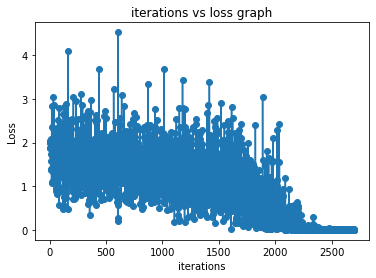

accuracy so far is  57.49999999999999  for batch size  4


In [90]:
# training on 360 samples to test the accuracy on SGD with 30 epoches
_ = train_and_test_my_model_with_sample(360,4,30,0.01, None,anuhya_fd)

300
1  epoch - cost of the batch is :  1.6864985807736714
2  epoch - cost of the batch is :  1.5273111414909364
3  epoch - cost of the batch is :  1.5017275126775105
4  epoch - cost of the batch is :  1.529769006272157
5  epoch - cost of the batch is :  1.478692589600881
6  epoch - cost of the batch is :  1.4824886655807494
7  epoch - cost of the batch is :  1.4587099003791808
8  epoch - cost of the batch is :  1.4487944038709004
9  epoch - cost of the batch is :  1.4737230372428893
10  epoch - cost of the batch is :  1.407446910937627
11  epoch - cost of the batch is :  1.4099471282958984
12  epoch - cost of the batch is :  1.4177062181631723
13  epoch - cost of the batch is :  1.3543181069691976
14  epoch - cost of the batch is :  1.3314519214630127
15  epoch - cost of the batch is :  1.3222055800755819
16  epoch - cost of the batch is :  1.3145730020602544
17  epoch - cost of the batch is :  1.2275809582074484
18  epoch - cost of the batch is :  1.1971820590893427
19  epoch - cost o

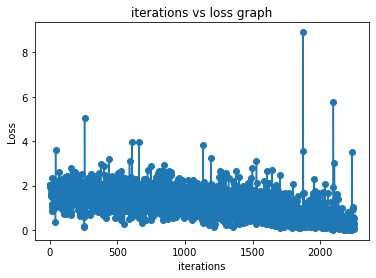

accuracy so far is  48.0  for batch size  4


In [91]:
# training on 300 samples to test the accuracy
_ = train_and_test_my_model_with_sample(300,4,30,0.01, None,anuhya_fd)

300
1  epoch - cost of the batch is :  3.6151415506998696
2  epoch - cost of the batch is :  1.5578092344601948
3  epoch - cost of the batch is :  1.5587040273348491
4  epoch - cost of the batch is :  1.5725682266553243
5  epoch - cost of the batch is :  1.571897852420807
6  epoch - cost of the batch is :  1.5516644136110942
7  epoch - cost of the batch is :  1.5545636018117268
8  epoch - cost of the batch is :  1.5523246455192565
9  epoch - cost of the batch is :  1.5497777462005615
10  epoch - cost of the batch is :  1.5484500734011333


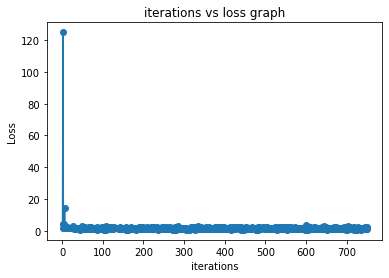

accuracy so far is  59.0  for batch size  4


In [88]:
# training on 300 samples to test the accuracy
_ = train_and_test_my_model_with_sample(300,4,10,0.01, None,anuhya_fd)

# checking accuray on revised annotated images of siddharth

In [27]:
df = pd.read_csv("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/train/training_data_set.csv")
classes = {'animal':0,'cartoon':1,'letter_numb':2,'plain':3,'printed':4,'squares':5,'stripes':6,'other':7}

In [28]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/siddharth/0.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/siddharth/'

data = pd.read_csv(path_to_csv)

sel = data['image']
bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

bboxes = bboxes.tolist()

df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))

siddharth_df = df_images

**Trying with SGD**

1  epoch - cost of the batch is :  1.6111671821276348
2  epoch - cost of the batch is :  1.4616393744945526
3  epoch - cost of the batch is :  1.4580358060201009
4  epoch - cost of the batch is :  1.4411396344502767
5  epoch - cost of the batch is :  1.4474149163564045
6  epoch - cost of the batch is :  1.4522995233535767
7  epoch - cost of the batch is :  1.4079350145657856
8  epoch - cost of the batch is :  1.4062119738260905
9  epoch - cost of the batch is :  1.41769855260849
10  epoch - cost of the batch is :  1.3757849550247192
11  epoch - cost of the batch is :  1.4025068791707356
12  epoch - cost of the batch is :  1.3630041114489237
13  epoch - cost of the batch is :  1.3667407517631849
14  epoch - cost of the batch is :  1.3643443421522776
15  epoch - cost of the batch is :  1.355624500910441
16  epoch - cost of the batch is :  1.3296547754605612
17  epoch - cost of the batch is :  1.3034580222765604
18  epoch - cost of the batch is :  1.2784903426965077
19  epoch - cost of th

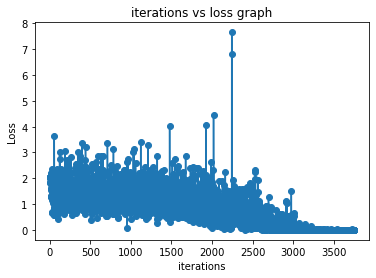

accuracy so far is  54.0  for batch size  4


In [32]:
# training on 300 samples to test the accuracy
_ = train_and_test_my_model_with_sample(300,4,50,0.01, None,siddharth_df)

1  epoch - cost of the batch is :  1.6086315042442745
2  epoch - cost of the batch is :  1.5315876324971518
3  epoch - cost of the batch is :  1.4589422080251906
4  epoch - cost of the batch is :  1.432850053575304
5  epoch - cost of the batch is :  1.437273669242859
6  epoch - cost of the batch is :  1.419969622294108
7  epoch - cost of the batch is :  1.418908766243193
8  epoch - cost of the batch is :  1.4166359298759037
9  epoch - cost of the batch is :  1.3962303741110695
10  epoch - cost of the batch is :  1.3963150802585813
11  epoch - cost of the batch is :  1.3754518296983507
12  epoch - cost of the batch is :  1.3688137590885163
13  epoch - cost of the batch is :  1.3525437937842475
14  epoch - cost of the batch is :  1.3512143949667612
15  epoch - cost of the batch is :  1.2982939942015541
16  epoch - cost of the batch is :  1.2627051975991992
17  epoch - cost of the batch is :  1.2133371531963348
18  epoch - cost of the batch is :  1.1955828534232245
19  epoch - cost of the

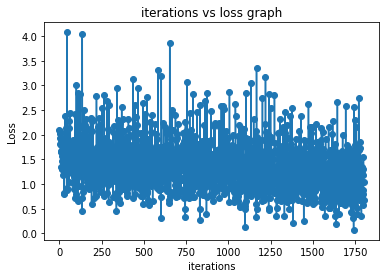

accuracy so far is  50.0  for batch size  4


In [30]:
_ = train_and_test_my_model_with_sample(360,4,30,0.01, None,siddharth_df)

1  epoch - cost of the batch is :  1.8607311938938342
2  epoch - cost of the batch is :  1.5302376872614811
3  epoch - cost of the batch is :  1.4902103668765019
4  epoch - cost of the batch is :  1.481459457623331
5  epoch - cost of the batch is :  1.4802682995796204
6  epoch - cost of the batch is :  1.4574810956653796
7  epoch - cost of the batch is :  1.4703414283300702
8  epoch - cost of the batch is :  1.4535907820651406
9  epoch - cost of the batch is :  1.4479007422924042
10  epoch - cost of the batch is :  1.4132484950517352
11  epoch - cost of the batch is :  1.4215101568322432
12  epoch - cost of the batch is :  1.395253471638027
13  epoch - cost of the batch is :  1.379432825665725
14  epoch - cost of the batch is :  1.419300537360342
15  epoch - cost of the batch is :  1.3852840599260832
16  epoch - cost of the batch is :  1.3624477762924998
17  epoch - cost of the batch is :  1.3417598981606333
18  epoch - cost of the batch is :  1.3205770003168207
19  epoch - cost of the

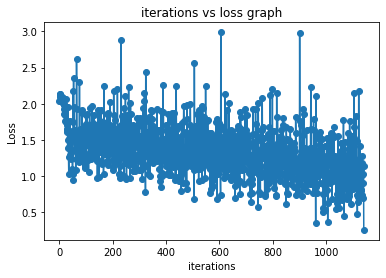

accuracy so far is  62.0  for batch size  8


In [33]:
# training on 300 samples to test the accuracy
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,siddharth_df)

1  epoch - cost of the batch is :  14.825510715183459
2  epoch - cost of the batch is :  1.3949930699248063
3  epoch - cost of the batch is :  1.3880455493927002
4  epoch - cost of the batch is :  1.38629455629148
5  epoch - cost of the batch is :  1.3850546573337756
6  epoch - cost of the batch is :  1.4042852081750568
7  epoch - cost of the batch is :  1.3790246279616105
8  epoch - cost of the batch is :  1.384078595199083
9  epoch - cost of the batch is :  1.3823025446189077
10  epoch - cost of the batch is :  1.379089123324344
11  epoch - cost of the batch is :  1.3811009604679911
12  epoch - cost of the batch is :  1.3715647317861255
13  epoch - cost of the batch is :  1.3816255927085876
14  epoch - cost of the batch is :  1.3865155734513934
15  epoch - cost of the batch is :  1.3893841159971136
16  epoch - cost of the batch is :  1.4003004933658398
17  epoch - cost of the batch is :  1.3768690197091353
18  epoch - cost of the batch is :  1.379205102983274
19  epoch - cost of the 

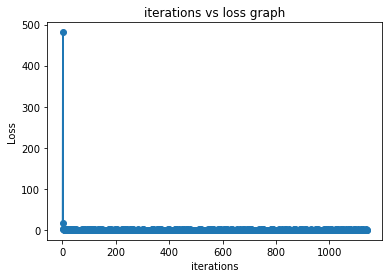

accuracy so far is  48.0  for batch size  8


In [35]:
# training on 300 samples to test the accuracy with Adam optimizer without batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,siddharth_df)

1  epoch - cost of the batch is :  3.8351908055218784
2  epoch - cost of the batch is :  1.4453975842757658
3  epoch - cost of the batch is :  1.4258936521681873
4  epoch - cost of the batch is :  1.3975326893004505
5  epoch - cost of the batch is :  1.413624101064422
6  epoch - cost of the batch is :  1.4129074270075017
7  epoch - cost of the batch is :  1.3847221054814078
8  epoch - cost of the batch is :  1.3901348357850856
9  epoch - cost of the batch is :  1.4216447621583939
10  epoch - cost of the batch is :  1.4537556320428848


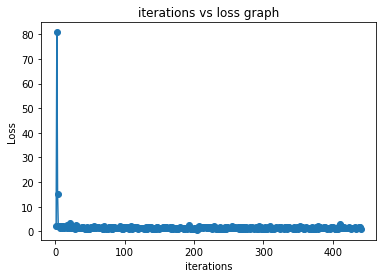

accuracy so far is  42.0  for batch size  8


In [36]:
# training on 300 samples to test the accuracy with Adam optimizer without batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(350,8,10,0.01, None,siddharth_df)

1  epoch - cost of the batch is :  5.029175021251043
2  epoch - cost of the batch is :  1.428621471590466
3  epoch - cost of the batch is :  1.409772057003445
4  epoch - cost of the batch is :  1.4055210590362548
5  epoch - cost of the batch is :  1.4028533478577931
6  epoch - cost of the batch is :  1.4102509644296435
7  epoch - cost of the batch is :  1.403368244568507
8  epoch - cost of the batch is :  1.404140262471305
9  epoch - cost of the batch is :  1.4027776969803705
10  epoch - cost of the batch is :  1.4008752829498714


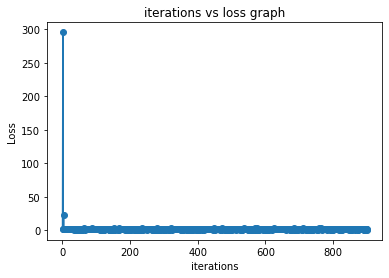

accuracy so far is  42.5  for batch size  4


In [37]:
# training on 300 samples to test the accuracy with Adam optimizer without batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,4,10,0.01, None,siddharth_df)

1  epoch - cost of the batch is :  28.514826613267264
2  epoch - cost of the batch is :  1.8172399632136027
3  epoch - cost of the batch is :  1.5629003469149272
4  epoch - cost of the batch is :  1.6317570980389913
5  epoch - cost of the batch is :  1.3862698944409688
6  epoch - cost of the batch is :  1.3758248829841613
7  epoch - cost of the batch is :  1.3711572829882304
8  epoch - cost of the batch is :  1.3690216032663982
9  epoch - cost of the batch is :  1.3621135250727336
10  epoch - cost of the batch is :  1.3606354880332947


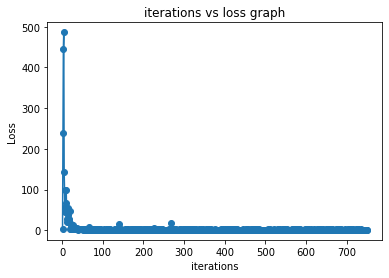

accuracy so far is  44.0  for batch size  4


In [40]:
# training on 300 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,4,10,0.01, None,siddharth_df)

1  epoch - cost of the batch is :  28.75012699553841
2  epoch - cost of the batch is :  1.8410289475792332
3  epoch - cost of the batch is :  1.8759911593637968
4  epoch - cost of the batch is :  1.5543257437254254
5  epoch - cost of the batch is :  1.4834711300699335
6  epoch - cost of the batch is :  1.4538303080358004
7  epoch - cost of the batch is :  1.4308927561107434
8  epoch - cost of the batch is :  1.409021994000987
9  epoch - cost of the batch is :  1.4133849865511845
10  epoch - cost of the batch is :  1.4016791048802828


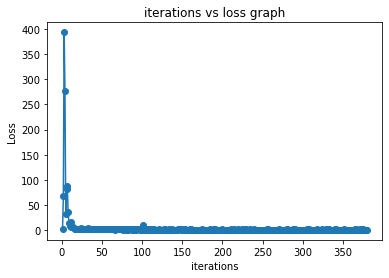

accuracy so far is  47.0  for batch size  8


In [41]:
# training on 300 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,8,10,0.01, None,siddharth_df)

In [ ]:
# training on 300 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,8,10,0.01, None,siddharth_df)

# checking accuray on revised annotated images of shiva data

In [42]:
df = pd.read_csv("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/train/training_data_set.csv")
classes = {'animal':0,'cartoon':1,'letter_numb':2,'plain':3,'printed':4,'squares':5,'stripes':6,'other':7}

In [43]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/shiva/3.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/shiva/'

data = pd.read_csv(path_to_csv)

sel = data['image']
bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

bboxes = bboxes.tolist()

df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))

shiva_df = df_images

1  epoch - cost of the batch is :  38.574384124655474
2  epoch - cost of the batch is :  1.9978210518234654
3  epoch - cost of the batch is :  1.6245970506417124
4  epoch - cost of the batch is :  1.5221368011675382
5  epoch - cost of the batch is :  1.4555882623321132
6  epoch - cost of the batch is :  1.4336817358669482
7  epoch - cost of the batch is :  1.4173249225867421
8  epoch - cost of the batch is :  1.4112480314154374
9  epoch - cost of the batch is :  1.3929199607748735
10  epoch - cost of the batch is :  1.3948740755256854


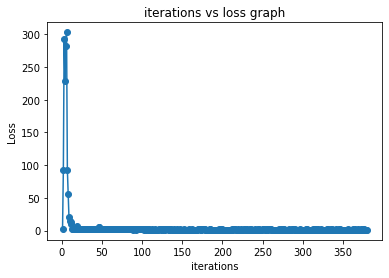

accuracy so far is  28.999999999999996  for batch size  8


In [44]:
# training on 300 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,8,10,0.01, None,shiva_df)

1  epoch - cost of the batch is :  30.905027551651003
2  epoch - cost of the batch is :  1.8160185496012369
3  epoch - cost of the batch is :  1.638442145983378
4  epoch - cost of the batch is :  1.5489480352401734
5  epoch - cost of the batch is :  1.5251085408528646
6  epoch - cost of the batch is :  1.5138867680231731
7  epoch - cost of the batch is :  1.5098219108581543
8  epoch - cost of the batch is :  1.5076121083895366
9  epoch - cost of the batch is :  1.546248418490092
10  epoch - cost of the batch is :  1.5089175327618918


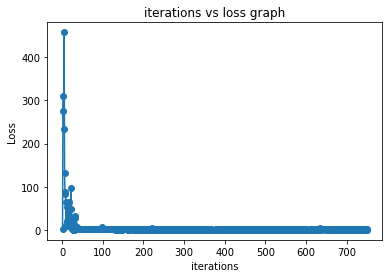

accuracy so far is  42.0  for batch size  4


In [45]:
# training on 300 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,4,10,0.01, None,shiva_df)

1  epoch - cost of the batch is :  24.670212332407633
2  epoch - cost of the batch is :  1.8545877880520292
3  epoch - cost of the batch is :  1.6461180263095432
4  epoch - cost of the batch is :  1.5311738491058349
5  epoch - cost of the batch is :  1.4963622490564983
6  epoch - cost of the batch is :  1.4781668504079184
7  epoch - cost of the batch is :  1.4687320391337078
8  epoch - cost of the batch is :  1.462172852622138
9  epoch - cost of the batch is :  1.4593289295832317
10  epoch - cost of the batch is :  1.45651363796658


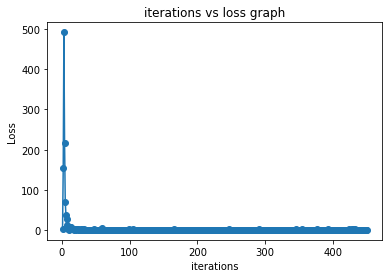

accuracy so far is  37.5  for batch size  8


In [46]:
# training on 360 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,8,10,0.01, None,shiva_df)

1  epoch - cost of the batch is :  34.75962074493107
2  epoch - cost of the batch is :  1.8481871987643994
3  epoch - cost of the batch is :  1.6996014243678044
4  epoch - cost of the batch is :  1.5637999396575124
5  epoch - cost of the batch is :  1.65333617674677
6  epoch - cost of the batch is :  1.5323152542114258
7  epoch - cost of the batch is :  1.4754630954642045
8  epoch - cost of the batch is :  1.585531328853808
9  epoch - cost of the batch is :  1.4965072619287592
10  epoch - cost of the batch is :  1.4488663924367804


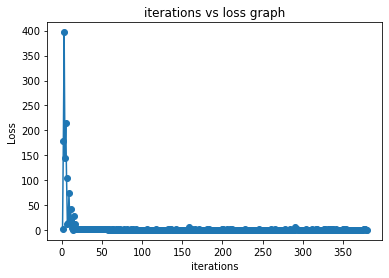

accuracy so far is  41.0  for batch size  8


In [47]:
# training on 300 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,8,10,0.01, None,shiva_df)

1  epoch - cost of the batch is :  56.147272420966104
2  epoch - cost of the batch is :  2.083570122718811
3  epoch - cost of the batch is :  1.8327854249788367
4  epoch - cost of the batch is :  1.7062181856321252
5  epoch - cost of the batch is :  1.6241776839546536
6  epoch - cost of the batch is :  1.5666372983351997
7  epoch - cost of the batch is :  1.5432722413021585
8  epoch - cost of the batch is :  1.6045509317646856
9  epoch - cost of the batch is :  1.4946171511774478
10  epoch - cost of the batch is :  1.494609791299571
11  epoch - cost of the batch is :  1.4825682640075684
12  epoch - cost of the batch is :  1.4822519240172014
13  epoch - cost of the batch is :  1.4668335759121438
14  epoch - cost of the batch is :  1.4673728061758953
15  epoch - cost of the batch is :  1.461441952249278
16  epoch - cost of the batch is :  1.459576824437017
17  epoch - cost of the batch is :  1.4800651799077573
18  epoch - cost of the batch is :  1.4614171981811523
19  epoch - cost of the

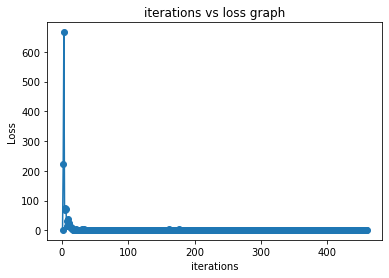

accuracy so far is  42.5  for batch size  16


In [48]:
# training on 360 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,16,20,0.01, None,shiva_df)

1  epoch - cost of the batch is :  15.90358021045408
2  epoch - cost of the batch is :  1.4703277764308345
3  epoch - cost of the batch is :  1.4734728545843003
4  epoch - cost of the batch is :  1.4557309875885645
5  epoch - cost of the batch is :  1.4627823235260116
6  epoch - cost of the batch is :  1.4710144587688976
7  epoch - cost of the batch is :  1.44166498945819
8  epoch - cost of the batch is :  1.4466106380025545
9  epoch - cost of the batch is :  1.522998199197981
10  epoch - cost of the batch is :  1.587977023422718
11  epoch - cost of the batch is :  1.4419191845589214
12  epoch - cost of the batch is :  1.5289243318965948
13  epoch - cost of the batch is :  1.4954806526501974
14  epoch - cost of the batch is :  1.4394078036149343
15  epoch - cost of the batch is :  1.438319616847568
16  epoch - cost of the batch is :  1.4397723969486025
17  epoch - cost of the batch is :  1.439496366845237
18  epoch - cost of the batch is :  1.4403003128038512
19  epoch - cost of the ba

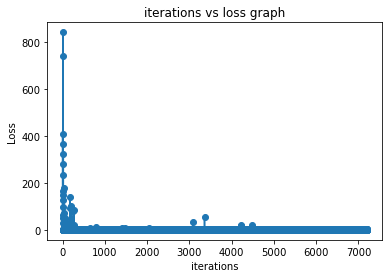

accuracy so far is  30.0  for batch size  1


In [49]:
# training on 360 samples to test the accuracy with Adam optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,1,20,0.01, None,shiva_df)

1  epoch - cost of the batch is :  1.565093003378974
2  epoch - cost of the batch is :  1.2804471174875895
3  epoch - cost of the batch is :  1.1556506885422602
4  epoch - cost of the batch is :  0.9000549382633634
5  epoch - cost of the batch is :  0.7500589076015685
6  epoch - cost of the batch is :  0.4738787955707974
7  epoch - cost of the batch is :  0.3470445256266329
8  epoch - cost of the batch is :  0.18297029545323718
9  epoch - cost of the batch is :  0.2776329769442479
10  epoch - cost of the batch is :  0.16676765272600783
11  epoch - cost of the batch is :  0.046878346567973496
12  epoch - cost of the batch is :  0.03734486361629226
13  epoch - cost of the batch is :  0.03570019039842817
14  epoch - cost of the batch is :  0.02828151784164624
15  epoch - cost of the batch is :  0.015564995469240886
16  epoch - cost of the batch is :  0.014545752476745595
17  epoch - cost of the batch is :  0.010639529694971214
18  epoch - cost of the batch is :  0.012837705627397453
19  e

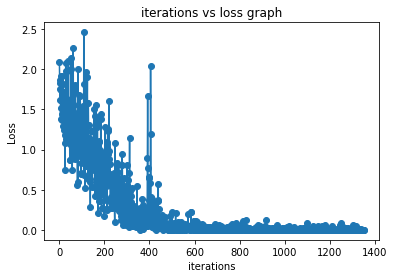

accuracy so far is  55.00000000000001  for batch size  8


In [53]:
# training on 360 samples to test the accuracy with SGD optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,8,30,0.01, None,shiva_df)

1  epoch - cost of the batch is :  1.6048691537645128
2  epoch - cost of the batch is :  1.3829071664147907
3  epoch - cost of the batch is :  1.17785442173481
4  epoch - cost of the batch is :  1.03725779387686
5  epoch - cost of the batch is :  0.8058871199687322
6  epoch - cost of the batch is :  0.5058710576966405
7  epoch - cost of the batch is :  0.36970755167098507
8  epoch - cost of the batch is :  0.28030172230986256
9  epoch - cost of the batch is :  0.16144524005487457
10  epoch - cost of the batch is :  0.07402468883471253
11  epoch - cost of the batch is :  0.07763146747682993
12  epoch - cost of the batch is :  0.15579090702619094
13  epoch - cost of the batch is :  0.020830162674085134
14  epoch - cost of the batch is :  0.015177477279485806
15  epoch - cost of the batch is :  0.019193029578602566
16  epoch - cost of the batch is :  0.013645878514752338
17  epoch - cost of the batch is :  0.007150022283447773
18  epoch - cost of the batch is :  0.0056789606507253315
19  

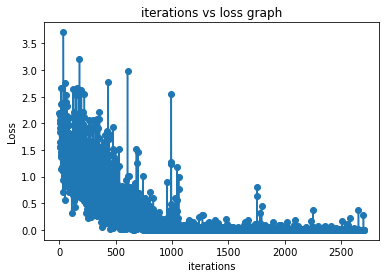

accuracy so far is  37.5  for batch size  4


In [54]:
# training on 360 samples to test the accuracy with SGD optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,4,30,0.01, None,shiva_df)

In [12]:
df = pd.read_csv("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/train/training_data_set.csv")
classes = {'animal':0,'cartoon':1,'letter_numb':2,'plain':3,'printed':4,'squares':5,'stripes':6,'other':7}

In [13]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/aryan/2.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/aryan/'

data = pd.read_csv(path_to_csv)

sel = data['image']
bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

bboxes = bboxes.tolist()

df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))

aryan_df = df_images

1  epoch - cost of the batch is :  1.5003295759359996
2  epoch - cost of the batch is :  1.2590695483816994
3  epoch - cost of the batch is :  1.0708668947219848
4  epoch - cost of the batch is :  0.8647331349137757
5  epoch - cost of the batch is :  0.6244972292644282
6  epoch - cost of the batch is :  0.4598801254501773
7  epoch - cost of the batch is :  0.1713938109025346
8  epoch - cost of the batch is :  0.0952864131284716
9  epoch - cost of the batch is :  0.07073867578583304
10  epoch - cost of the batch is :  0.03578285369418761
11  epoch - cost of the batch is :  0.09059312552077851
12  epoch - cost of the batch is :  0.026090101172040806
13  epoch - cost of the batch is :  0.020096107016110587
14  epoch - cost of the batch is :  0.018372951518447027
15  epoch - cost of the batch is :  0.011165244712052906
16  epoch - cost of the batch is :  0.007711553418461234
17  epoch - cost of the batch is :  0.007991705080828776
18  epoch - cost of the batch is :  0.023522469966653463
19

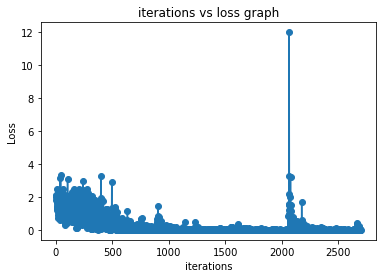

accuracy so far is  72.5  for batch size  4


In [61]:
# training on 360 samples to test the accuracy with SGD optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,4,30,0.01, None,aryan_df)

1  epoch - cost of the batch is :  1.4932498269610934
2  epoch - cost of the batch is :  1.226943035920461
3  epoch - cost of the batch is :  1.0819359355502658
4  epoch - cost of the batch is :  0.8838859438896179
5  epoch - cost of the batch is :  0.684275507595804
6  epoch - cost of the batch is :  0.4266567760043674
7  epoch - cost of the batch is :  0.29019355128208796
8  epoch - cost of the batch is :  0.14631715992258654
9  epoch - cost of the batch is :  0.07353142550111645
10  epoch - cost of the batch is :  0.055821486658209726
11  epoch - cost of the batch is :  0.042699426280645034
12  epoch - cost of the batch is :  0.033232637499976486
13  epoch - cost of the batch is :  0.025903306658276254
14  epoch - cost of the batch is :  0.019880660126606622
15  epoch - cost of the batch is :  0.01418302546436381
16  epoch - cost of the batch is :  0.016796085255919024
17  epoch - cost of the batch is :  0.012807920320321702
18  epoch - cost of the batch is :  0.010949897738949705
1

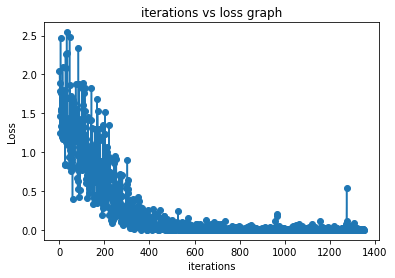

accuracy so far is  62.5  for batch size  8


In [62]:
# training on 360 samples to test the accuracy with SGD optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(360,8,30,0.01, None,aryan_df)

1  epoch - cost of the batch is :  1.545806000630061
2  epoch - cost of the batch is :  1.360797409216563
3  epoch - cost of the batch is :  1.2105451015631359
4  epoch - cost of the batch is :  1.054328122138977
5  epoch - cost of the batch is :  0.7819112599889437
6  epoch - cost of the batch is :  0.4925598404929042
7  epoch - cost of the batch is :  0.33537879134217896
8  epoch - cost of the batch is :  0.14536125966037314
9  epoch - cost of the batch is :  0.228361465887477
10  epoch - cost of the batch is :  0.08854712046255979
11  epoch - cost of the batch is :  0.03544616590889443
12  epoch - cost of the batch is :  0.025918244642689388
13  epoch - cost of the batch is :  0.01379807255804432
14  epoch - cost of the batch is :  0.008025666897437986
15  epoch - cost of the batch is :  0.006980815660572261
16  epoch - cost of the batch is :  0.006967312612559908
17  epoch - cost of the batch is :  0.005192049905956537
18  epoch - cost of the batch is :  0.003693523627383305
19  ep

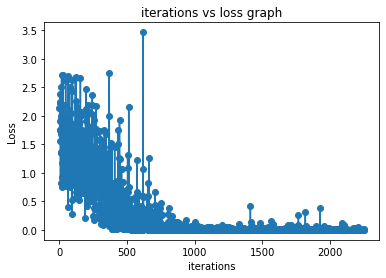

accuracy so far is  55.00000000000001  for batch size  4


In [63]:
# training on 360 samples to test the accuracy with SGD optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,4,30,0.01, None,aryan_df)

1  epoch - cost of the batch is :  1.5400467907127582
2  epoch - cost of the batch is :  1.303243809624722
3  epoch - cost of the batch is :  1.142363411815543
4  epoch - cost of the batch is :  1.0395182128015317
5  epoch - cost of the batch is :  0.786492426928721
6  epoch - cost of the batch is :  0.6238089948892593
7  epoch - cost of the batch is :  0.42487963289022446
8  epoch - cost of the batch is :  0.2580804004284896
9  epoch - cost of the batch is :  0.1543978718109429
10  epoch - cost of the batch is :  0.12024079657796967
11  epoch - cost of the batch is :  0.08536909016976624
12  epoch - cost of the batch is :  0.045317068371284554
13  epoch - cost of the batch is :  0.0234223519893069
14  epoch - cost of the batch is :  0.024927556128731293
15  epoch - cost of the batch is :  0.014380276674943926
16  epoch - cost of the batch is :  0.17514552379495735
17  epoch - cost of the batch is :  0.03213745270592259
18  epoch - cost of the batch is :  0.018611665841155246
19  epoch

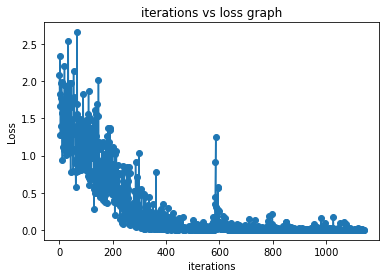

accuracy so far is  59.0  for batch size  8


In [64]:
# training on 360 samples to test the accuracy with SGD optimizer, batchnorm and dropout layers
_ = train_and_test_my_model_with_sample(300,8,30,0.01, None,aryan_df)

**trying with Adam optimizer, batchnorm layer and dropout layer combined**

1  epoch - cost of the batch is :  36.74386794316141
2  epoch - cost of the batch is :  1.7527701258659363
3  epoch - cost of the batch is :  1.5861696789139195
4  epoch - cost of the batch is :  1.4837586095458584
5  epoch - cost of the batch is :  1.435946031620628
6  epoch - cost of the batch is :  1.407722211197803
7  epoch - cost of the batch is :  1.3932292555507861
8  epoch - cost of the batch is :  1.391949165808527
9  epoch - cost of the batch is :  1.3751306612240641
10  epoch - cost of the batch is :  1.3799402807888232
11  epoch - cost of the batch is :  1.372012552462126
12  epoch - cost of the batch is :  1.3625963565550352
13  epoch - cost of the batch is :  1.368112895049547
14  epoch - cost of the batch is :  1.364513292124397
15  epoch - cost of the batch is :  1.3629083429512225


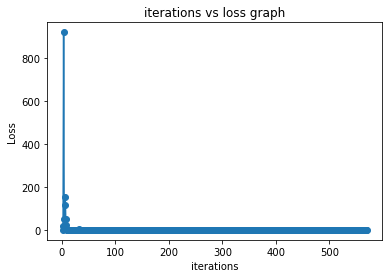

accuracy so far is  53.0  for batch size  8


In [70]:
_ = train_and_test_my_model_with_sample(300,8,15,0.01, None,aryan_df)

1  epoch - cost of the batch is :  21.82907204548518
2  epoch - cost of the batch is :  1.61563814163208
3  epoch - cost of the batch is :  1.460240157445272
4  epoch - cost of the batch is :  1.4162727308273315
5  epoch - cost of the batch is :  1.381764578819275
6  epoch - cost of the batch is :  1.3741183503468832
7  epoch - cost of the batch is :  1.366231419245402
8  epoch - cost of the batch is :  1.3654247697194417
9  epoch - cost of the batch is :  1.361598776181539
10  epoch - cost of the batch is :  1.3593789370854696
11  epoch - cost of the batch is :  1.3609127871195474
12  epoch - cost of the batch is :  1.3550440073013306
13  epoch - cost of the batch is :  1.357923023700714
14  epoch - cost of the batch is :  1.355447915395101
15  epoch - cost of the batch is :  1.5905114539464316


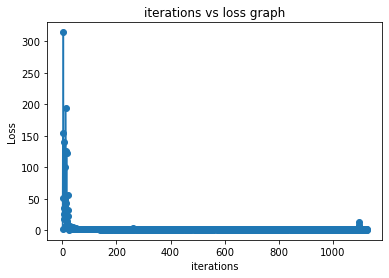

accuracy so far is  50.0  for batch size  4


In [71]:
_ = train_and_test_my_model_with_sample(300,4,15,0.01, None,aryan_df)

1  epoch - cost of the batch is :  25.795957798428006
2  epoch - cost of the batch is :  1.8608493910895454
3  epoch - cost of the batch is :  1.5956833839416504
4  epoch - cost of the batch is :  1.4510537571377224
5  epoch - cost of the batch is :  1.4020741873317295
6  epoch - cost of the batch is :  1.3829772737291124
7  epoch - cost of the batch is :  1.367801378832923
8  epoch - cost of the batch is :  1.358165062798394
9  epoch - cost of the batch is :  1.3539788828955757
10  epoch - cost of the batch is :  1.3466602153248257
11  epoch - cost of the batch is :  1.3474252038531833
12  epoch - cost of the batch is :  1.3455941597620646
13  epoch - cost of the batch is :  1.344179662068685
14  epoch - cost of the batch is :  1.3428234616915384
15  epoch - cost of the batch is :  1.3420169009102716


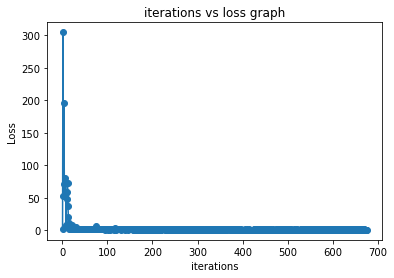

accuracy so far is  50.0  for batch size  8


In [72]:
_ = train_and_test_my_model_with_sample(360,8,15,0.01, None,aryan_df)

1  epoch - cost of the batch is :  21.70389046801461
2  epoch - cost of the batch is :  1.680192642741733
3  epoch - cost of the batch is :  1.6526857886049482
4  epoch - cost of the batch is :  1.3859343780411615
5  epoch - cost of the batch is :  1.3379802313115863
6  epoch - cost of the batch is :  1.3329771949185265
7  epoch - cost of the batch is :  1.3301437099774678
8  epoch - cost of the batch is :  1.3492867277728187
9  epoch - cost of the batch is :  1.3265271570947434
10  epoch - cost of the batch is :  1.3273453215758007
11  epoch - cost of the batch is :  1.3257019380728403
12  epoch - cost of the batch is :  1.3251545641157363
13  epoch - cost of the batch is :  1.3246839357746971
14  epoch - cost of the batch is :  1.3234356780846914
15  epoch - cost of the batch is :  1.3240665833155314


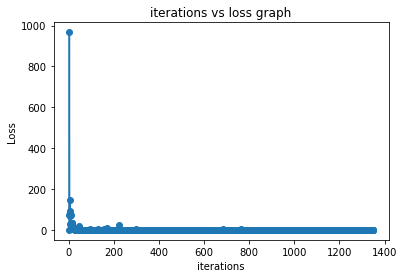

accuracy so far is  40.0  for batch size  4


In [73]:
_ = train_and_test_my_model_with_sample(360,4,15,0.01, None,aryan_df)

In [16]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/mixed.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/'

data = pd.read_csv(path_to_csv)

sel = data['image']
bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

bboxes = bboxes.tolist()

df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))

1  epoch - cost of the batch is :  1.6420776622635977
2  epoch - cost of the batch is :  1.564999007838113
3  epoch - cost of the batch is :  1.5044953771999905
4  epoch - cost of the batch is :  1.4856202023369924
5  epoch - cost of the batch is :  1.416802202292851
6  epoch - cost of the batch is :  1.3287044642652783
7  epoch - cost of the batch is :  1.2079625826222555
8  epoch - cost of the batch is :  1.0356184712052345
9  epoch - cost of the batch is :  0.7727327959558793
10  epoch - cost of the batch is :  0.6466341017612389
11  epoch - cost of the batch is :  0.5170200473761984
12  epoch - cost of the batch is :  0.38591545905452224
13  epoch - cost of the batch is :  0.2545305322336831
14  epoch - cost of the batch is :  0.2285585009240146
15  epoch - cost of the batch is :  0.18864121352704907
16  epoch - cost of the batch is :  0.18597224898104156
17  epoch - cost of the batch is :  0.1491014524086703
18  epoch - cost of the batch is :  0.16988822541309803
19  epoch - cost 

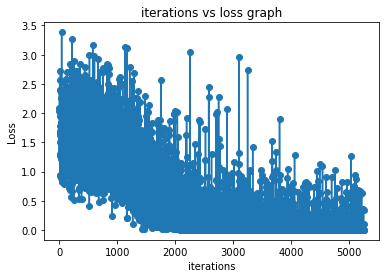

accuracy so far is  34.0  for batch size  4


In [18]:
# training on 700 samples to test the accuracy with SGD optimizer, with batchnorm and dropout layers when both anuhya and shiva data mixed
_ = train_and_test_my_model_with_sample(700,4,30,0.01, None,df_images)

1  epoch - cost of the batch is :  1.6232754780186547
2  epoch - cost of the batch is :  1.526562527153227
3  epoch - cost of the batch is :  1.468487427632014
4  epoch - cost of the batch is :  1.3772652235296037
5  epoch - cost of the batch is :  1.3249573124779594
6  epoch - cost of the batch is :  1.1791292442215813
7  epoch - cost of the batch is :  0.968646639585495
8  epoch - cost of the batch is :  0.7948644154601627
9  epoch - cost of the batch is :  0.5859539796908696
10  epoch - cost of the batch is :  0.3881409463369184
11  epoch - cost of the batch is :  0.31742394525143836
12  epoch - cost of the batch is :  0.24535947057625485
13  epoch - cost of the batch is :  0.19212571063803302
14  epoch - cost of the batch is :  0.17837539227782853
15  epoch - cost of the batch is :  0.18026955905629116
16  epoch - cost of the batch is :  0.13033612033403996
17  epoch - cost of the batch is :  0.10392839620730633
18  epoch - cost of the batch is :  0.08290896362418101
19  epoch - co

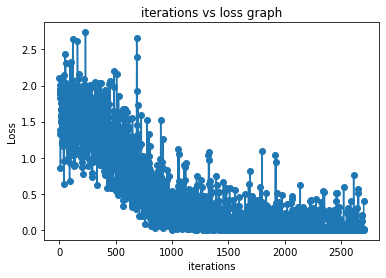

accuracy so far is  35.0  for batch size  8


In [20]:
# training on 720 samples to test the accuracy with SGD optimizer, with batchnorm and dropout layers when both anuhya and shiva data mixed with batch size 8
_ = train_and_test_my_model_with_sample(720,8,30,0.01, None,df_images)

1  epoch - cost of the batch is :  1.6472178419431052
2  epoch - cost of the batch is :  1.479919515715705
3  epoch - cost of the batch is :  1.408663582139545
4  epoch - cost of the batch is :  1.2734009404977162
5  epoch - cost of the batch is :  1.070555830664105
6  epoch - cost of the batch is :  0.9073444532023536
7  epoch - cost of the batch is :  0.637230641891559
8  epoch - cost of the batch is :  0.40861531823045677
9  epoch - cost of the batch is :  0.3297879206637541
10  epoch - cost of the batch is :  0.22386595581968624
11  epoch - cost of the batch is :  0.20124408441285294
12  epoch - cost of the batch is :  0.14576088769568338
13  epoch - cost of the batch is :  0.11727705545102557
14  epoch - cost of the batch is :  0.07854437114179341
15  epoch - cost of the batch is :  0.12449187025292001
16  epoch - cost of the batch is :  0.06991899848346494
17  epoch - cost of the batch is :  0.08969144159798614
18  epoch - cost of the batch is :  0.05931541599339754
19  epoch - c

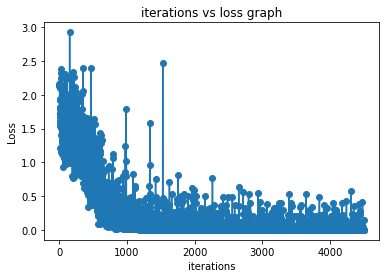

accuracy so far is  36.25  for batch size  8


In [22]:
# training on 720 samples to test the accuracy with SGD optimizer, with batchnorm and dropout layers when both anuhya and shiva data mixed with batch size 8
_ = train_and_test_my_model_with_sample(720,8,50,0.007, None,df_images)

1  epoch - cost of the batch is :  1.8523646606339348
2  epoch - cost of the batch is :  1.616060514582528
3  epoch - cost of the batch is :  1.5670927902062735
4  epoch - cost of the batch is :  1.5471297628349727
5  epoch - cost of the batch is :  1.5384445806344351
6  epoch - cost of the batch is :  1.5330575188000997
7  epoch - cost of the batch is :  1.5278323292732239
8  epoch - cost of the batch is :  1.5216535217232174
9  epoch - cost of the batch is :  1.519184829129113
10  epoch - cost of the batch is :  1.5129586299260458
11  epoch - cost of the batch is :  1.51655134095086
12  epoch - cost of the batch is :  1.5098245918750763
13  epoch - cost of the batch is :  1.502872700823678
14  epoch - cost of the batch is :  1.5060836056868234
15  epoch - cost of the batch is :  1.5166048632727729
16  epoch - cost of the batch is :  1.4941808760166169
17  epoch - cost of the batch is :  1.4950500296221838
18  epoch - cost of the batch is :  1.4889016018973456
19  epoch - cost of the 

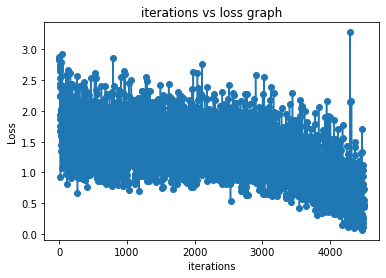

accuracy so far is  35.0  for batch size  8


In [24]:
# training on 720 samples to test the accuracy with SGD optimizer, without batchnorm and dropout layers when both anuhya and shiva data mixed with batch size 8
_ = train_and_test_my_model_with_sample(720,8,50,0.007, None,df_images)

1  epoch - cost of the batch is :  1.8231731302208372
2  epoch - cost of the batch is :  1.5739803976482816
3  epoch - cost of the batch is :  1.539906038178338
4  epoch - cost of the batch is :  1.5184193472067515
5  epoch - cost of the batch is :  1.503924873802397
6  epoch - cost of the batch is :  1.5027436481581793
7  epoch - cost of the batch is :  1.5129437214798398
8  epoch - cost of the batch is :  1.4981837285889519
9  epoch - cost of the batch is :  1.493561249309116
10  epoch - cost of the batch is :  1.4976314114199745
11  epoch - cost of the batch is :  1.5009114464124045
12  epoch - cost of the batch is :  1.4963405271371206
13  epoch - cost of the batch is :  1.4829748372236888
14  epoch - cost of the batch is :  1.4829761425654093
15  epoch - cost of the batch is :  1.4866310483879512
16  epoch - cost of the batch is :  1.4837871015071868
17  epoch - cost of the batch is :  1.475821816921234
18  epoch - cost of the batch is :  1.4804802258809409
19  epoch - cost of the

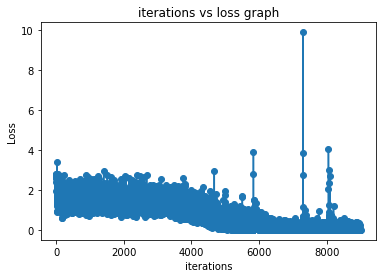

accuracy so far is  33.75  for batch size  8


In [25]:
# training on 720 samples to test the accuracy with SGD optimizer, without batchnorm and dropout layers when both anuhya and shiva data mixed with batch size 8
_ = train_and_test_my_model_with_sample(720,8,100,0.007, None,df_images)

1  epoch - cost of the batch is :  8.110882016685274
2  epoch - cost of the batch is :  1.5069453795750936
3  epoch - cost of the batch is :  1.5089844783147177
4  epoch - cost of the batch is :  1.497147646215227
5  epoch - cost of the batch is :  1.4981034947766199
6  epoch - cost of the batch is :  1.496025890774197
7  epoch - cost of the batch is :  1.4971360537740919
8  epoch - cost of the batch is :  1.4954912642637888
9  epoch - cost of the batch is :  1.4957293815082975
10  epoch - cost of the batch is :  1.501582043700748
11  epoch - cost of the batch is :  1.5013554910818736
12  epoch - cost of the batch is :  1.4899913350741067
13  epoch - cost of the batch is :  1.4879056321250068
14  epoch - cost of the batch is :  1.4907298644383749
15  epoch - cost of the batch is :  1.4909500393602584
16  epoch - cost of the batch is :  1.4866988380750021
17  epoch - cost of the batch is :  1.4914967040220897
18  epoch - cost of the batch is :  1.4882131245401171
19  epoch - cost of the

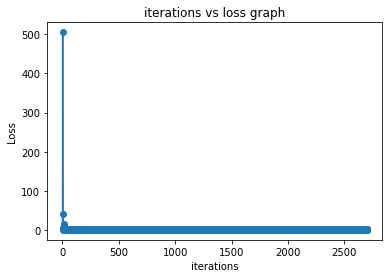

accuracy so far is  40.0  for batch size  8


In [28]:
# training on 720 samples to test the accuracy with ADAM optimizer, without batchnorm and dropout layers when both anuhya and shiva data mixed with batch size 8
_ = train_and_test_my_model_with_sample(720,8,30,0.007, None,df_images)

In [30]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/mixed.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/'

data = pd.read_csv(path_to_csv)

sel = data['image']
bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

bboxes = bboxes.tolist()

df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))

In [31]:
len(df_images)

1200

1  epoch - cost of the batch is :  8.420827469963958
2  epoch - cost of the batch is :  1.5539036125376604
3  epoch - cost of the batch is :  1.472933758860049
4  epoch - cost of the batch is :  1.4520951531071593
5  epoch - cost of the batch is :  1.452555707399396
6  epoch - cost of the batch is :  1.4401833021986312
7  epoch - cost of the batch is :  1.4413109534028647
8  epoch - cost of the batch is :  1.4364826558292776
9  epoch - cost of the batch is :  1.4359990366991016
10  epoch - cost of the batch is :  1.4400756600974263
11  epoch - cost of the batch is :  1.4373653267604718
12  epoch - cost of the batch is :  1.4446456337320632
13  epoch - cost of the batch is :  1.4389031728108723
14  epoch - cost of the batch is :  1.43752444697463
15  epoch - cost of the batch is :  1.4395195509212604
16  epoch - cost of the batch is :  1.4408277597116388
17  epoch - cost of the batch is :  1.4363666746927344
18  epoch - cost of the batch is :  1.4373852390310038
19  epoch - cost of the 

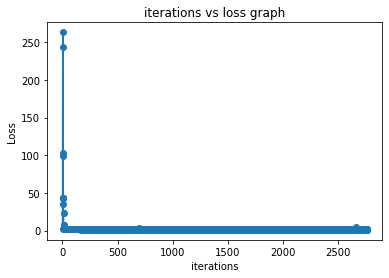

accuracy so far is  46.0  for batch size  8


In [34]:
# training on 720 samples to test the accuracy with ADAM optimizer, with batchnorm and dropout layers when both anuhya, shiva and aryan data mixed with batch size 8
_ = train_and_test_my_model_with_sample(1100,8,20,0.007, None,df_images)

1  epoch - cost of the batch is :  6.552552187226035
2  epoch - cost of the batch is :  1.4695105678384954
3  epoch - cost of the batch is :  1.4501797327128323
4  epoch - cost of the batch is :  1.4408965056592768
5  epoch - cost of the batch is :  1.439346539107236
6  epoch - cost of the batch is :  1.4391371646794406
7  epoch - cost of the batch is :  1.4384799027442932
8  epoch - cost of the batch is :  1.438727006261999
9  epoch - cost of the batch is :  1.4393277328664607
10  epoch - cost of the batch is :  1.439601684700359
11  epoch - cost of the batch is :  1.4386688512021846
12  epoch - cost of the batch is :  1.4391538765213707
13  epoch - cost of the batch is :  1.4396557276899165
14  epoch - cost of the batch is :  1.5916686309467662
15  epoch - cost of the batch is :  1.4446776270866395
16  epoch - cost of the batch is :  1.453364203192971
17  epoch - cost of the batch is :  1.6148856659369035
18  epoch - cost of the batch is :  1.4398261668465355
19  epoch - cost of the 

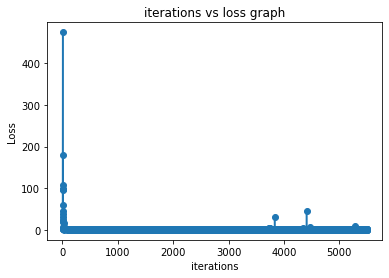

accuracy so far is  47.0  for batch size  4


In [35]:
# training on 720 samples to test the accuracy with ADAM optimizer, with batchnorm and dropout layers when both anuhya, shiva and aryan data mixed with batch size 8
_ = train_and_test_my_model_with_sample(1100,4,20,0.007, None,df_images)

1  epoch - cost of the batch is :  6.183912642652338
2  epoch - cost of the batch is :  1.4606739547035912
3  epoch - cost of the batch is :  1.424687691818584
4  epoch - cost of the batch is :  1.4237833519415422
5  epoch - cost of the batch is :  1.4240471607988532
6  epoch - cost of the batch is :  1.4824871388348666
7  epoch - cost of the batch is :  1.4257511366497386
8  epoch - cost of the batch is :  1.4234913353486494
9  epoch - cost of the batch is :  1.4278911618752914
10  epoch - cost of the batch is :  1.432839085405523
11  epoch - cost of the batch is :  1.591498412435705
12  epoch - cost of the batch is :  1.4237621086294001
13  epoch - cost of the batch is :  1.4237223427945918
14  epoch - cost of the batch is :  1.4258298149975863
15  epoch - cost of the batch is :  1.4239465067603372
16  epoch - cost of the batch is :  1.424593491337516
17  epoch - cost of the batch is :  1.4236883313005622
18  epoch - cost of the batch is :  1.4251808313889938
19  epoch - cost of the 

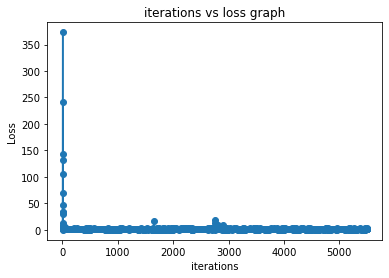

accuracy so far is  45.0  for batch size  4


In [36]:
# training on 720 samples to test the accuracy with ADAM optimizer, with batchnorm and dropout layers when both anuhya, shiva and aryan data mixed with batch size 8
_ = train_and_test_my_model_with_sample(1100,4,20,0.01, None,df_images)

1  epoch - cost of the batch is :  12.385465539020041
2  epoch - cost of the batch is :  1.4721855560074681
3  epoch - cost of the batch is :  1.4332950499610624
4  epoch - cost of the batch is :  1.4306847297626992
5  epoch - cost of the batch is :  1.4272340773672298
6  epoch - cost of the batch is :  1.425293663273687
7  epoch - cost of the batch is :  1.4252709478571794
8  epoch - cost of the batch is :  1.4232396712337716
9  epoch - cost of the batch is :  1.4245640315871309
10  epoch - cost of the batch is :  1.42437776664029
11  epoch - cost of the batch is :  1.4381487261557924
12  epoch - cost of the batch is :  1.478240217419638
13  epoch - cost of the batch is :  1.4226294362890548
14  epoch - cost of the batch is :  1.4245897492636805
15  epoch - cost of the batch is :  1.4264322735261226
16  epoch - cost of the batch is :  1.4241087851317034
17  epoch - cost of the batch is :  1.4745337021523628
18  epoch - cost of the batch is :  1.5531458167926124
19  epoch - cost of the

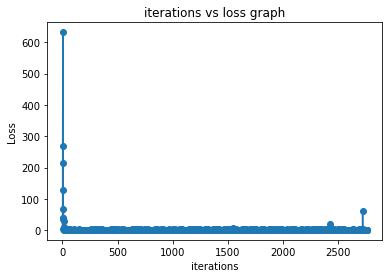

accuracy so far is  43.0  for batch size  8


In [37]:
# training on 720 samples to test the accuracy with ADAM optimizer, with batchnorm and dropout layers when both anuhya, shiva and aryan data mixed with batch size 8
_ = train_and_test_my_model_with_sample(1100,8,20,0.01, None,df_images)

In [38]:
# training on 720 samples to test the accuracy with ADAM optimizer, with batchnorm and dropout layers when both anuhya, shiva and aryan data mixed with batch size 8
# _ = train_and_test_my_model_with_sample(1100,4,20,0.01, None,df_images)

**should try SGD with momentum**

In [39]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/mixed.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/'

data = pd.read_csv(path_to_csv)

sel = data['image']
bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

bboxes = bboxes.tolist()

df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i])),classes[data['pattern'][i]]))

In [83]:
sel = data['image']
len(sel)

1600

In [84]:
data.head()

,image,pattern
0,014671.jpg,plain
1,014676.jpg,printed
2,014677.jpg,printed
3,014708.jpg,stripes
4,014746.jpg,plain


In [69]:
df.head()

,product_id,category_id,bounding_box,occlusion,viewpoint,zoom-in,image
0,P00003,10,"[1, 52, 467, 831]",1,1,2,000003.jpg
1,P00004,10,"[0, 113, 467, 623]",1,2,2,000004.jpg
2,P00005,10,"[1, 98, 467, 814]",1,1,2,000005.jpg
3,P00006,10,"[0, 324, 466, 831]",3,2,2,000006.jpg
4,P00007,10,"[23, 106, 430, 696]",1,1,1,000007.jpg


In [121]:
bounding_lst = list()
for i in range(len(data)):
    bounding_lst.append((df[df['image']==data['image'][i]])['bounding_box'])

In [122]:
bounding_lst = list()
for i in range(len(data)):
    bounding_lst.append((df[df['image']==data['image'][i]])['bounding_box'])
bboxes = list()
for i in range(len(bounding_lst)):
    bboxes.append(stringToList(list(bounding_lst[104])[0]))

[343, 190, 520, 577]

In [107]:
print(bounding_lst[20],"**********",data['image'][20])

6209    [32, 208, 447, 621]
Name: bounding_box, dtype: object ********** 015040.jpg


In [116]:
stringToList(list(bounding_lst[104])[0])

[343, 190, 520, 577]

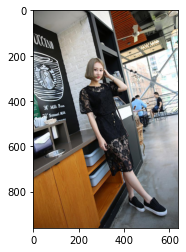

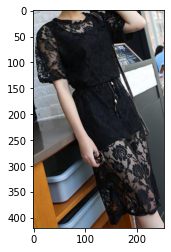

In [118]:
_ = imageWithBoundingBoxC(stringToList(list(bounding_lst[105])[0]),data['image'][105])

In [80]:
df[df['image']=="016873.jpg"]

,product_id,category_id,bounding_box,occlusion,viewpoint,zoom-in,image
6874,P16873,9,"[236, 323, 568, 852]",1,3,1,016873.jpg


In [114]:
def imageWithBoundingBoxC(bbox, no):
    # bbox=[236, 323, 568, 852]
    im = Image.open("C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/"+no)
    displayImage(im)
    im1 = im.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    displayImage(im1)
    transform =  transforms.ToTensor()
    tensor_image = transform(im1)
    resize = transforms.Resize([224, 224])
    return resize(tensor_image.type(torch.FloatTensor))

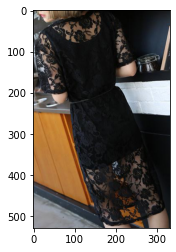

016873.jpg [56, 1, 443, 345]


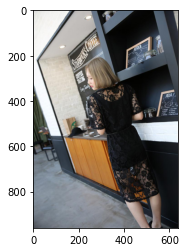

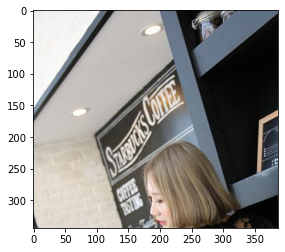

In [79]:
i=np.random.randint(0,len(data))
_ = convertImageToTensorWithBBox(data['image'][i],stringToList(bboxes[i]))

In [40]:
mixed=df_images

1  epoch - cost of the batch is :  5.9420156947771705
2  epoch - cost of the batch is :  1.4334861868222555
3  epoch - cost of the batch is :  1.4461549428304037
4  epoch - cost of the batch is :  1.4288188843727112
5  epoch - cost of the batch is :  1.4287840708096822
6  epoch - cost of the batch is :  1.4319959074656168
7  epoch - cost of the batch is :  2.310299235979716
8  epoch - cost of the batch is :  1.4313714097340902
9  epoch - cost of the batch is :  1.4294540586471558
10  epoch - cost of the batch is :  1.4333662625948589
11  epoch - cost of the batch is :  1.4283890097935994
12  epoch - cost of the batch is :  1.4275394945144653
13  epoch - cost of the batch is :  1.42884903160731
14  epoch - cost of the batch is :  1.5836732511520386
15  epoch - cost of the batch is :  1.440339276790619
16  epoch - cost of the batch is :  1.4302826401392619
17  epoch - cost of the batch is :  1.4291090005238851
18  epoch - cost of the batch is :  1.427669438680013
19  epoch - cost of the 

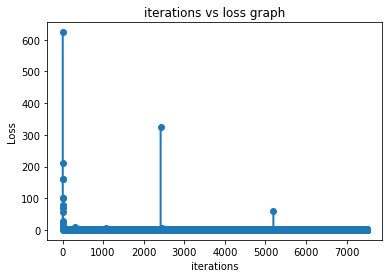

accuracy so far is  49.0  for batch size  4


In [41]:
# training on 720 samples to test the accuracy with ADAM optimizer, with batchnorm and dropout layers when both anuhya, shiva and aryan data mixed with batch size 8
_ = train_and_test_my_model_with_sample(1500,4,20,0.01, None,mixed)

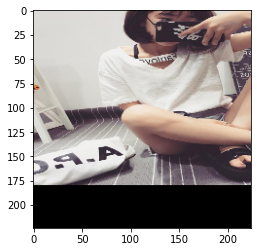

In [63]:
displayImage(mixed[0][0].numpy().transpose(1,2,0))

In [47]:
classes = {'animal':0,'cartoon':1,'letter_numb':2,'plain':3,'printed':4,'squares':5,'stripes':6,'other':7}
reversed_classes = {0:"animal",1:"cartoon",2:"letter_numb",3:"plain",4:"printed",5:"squares",6:"stripes",7:"other"}

In [49]:
def sample_checker(data,index):
    plt.imshow(np.array(data[index][0]))
    plt.show()
    print("actual - ",reversed_classes[data[index][1]],"\tpredicted - ",reversed_classes[data[index][2]])

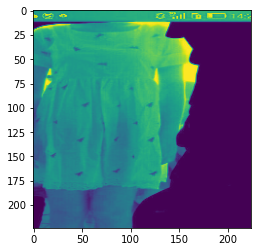

actual -  printed 	predicted -  plain


In [50]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

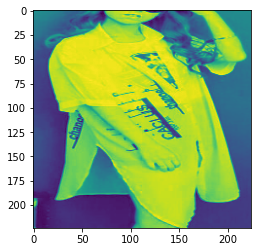

actual -  printed 	predicted -  plain


In [51]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

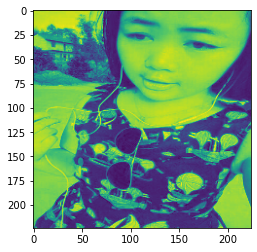

actual -  printed 	predicted -  plain


In [52]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

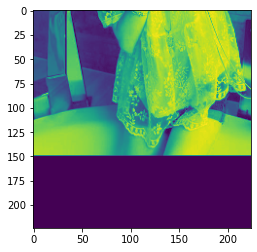

actual -  printed 	predicted -  plain


In [53]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

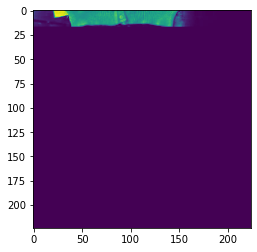

actual -  printed 	predicted -  plain


In [54]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

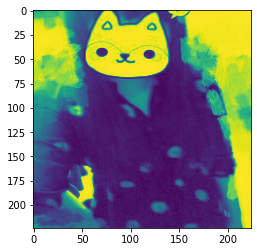

actual -  printed 	predicted -  plain


In [55]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

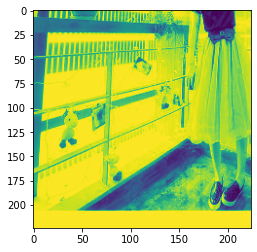

actual -  letter_numb 	predicted -  plain


In [56]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

In [131]:
def convertImageToTensorWithBBox(image_name, bbox):
    original_image = Image.open(path_to_images+image_name)
    # print(image_name,bbox)
    # displayImage(original_image)
    cropped_image = original_image.copy().crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    # displayImage(cropped_image)
    transform =  transforms.ToTensor()
    tensor_image = transform(cropped_image)
    
    resize = transforms.Resize([224, 224])
    return resize(tensor_image.type(torch.FloatTensor))

In [132]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/mixed.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/mixed/'

data = pd.read_csv(path_to_csv)

# sel = data['image']
# bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

# bboxes = bboxes.tolist()

bounding_lst = list()
for i in range(len(data)):
    bounding_lst.append((df[df['image']==data['image'][i]])['bounding_box'])
bboxes = list()
for i in range(len(bounding_lst)):
    bboxes.append(stringToList(list(bounding_lst[i])[0]))



df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],bboxes[i]),classes[data['pattern'][i]]))

In [133]:
mixed = df_images

1  epoch - cost of the batch is :  7.246405345042547
2  epoch - cost of the batch is :  1.4470839071273804
3  epoch - cost of the batch is :  1.4304513527552287
4  epoch - cost of the batch is :  1.4394844504992168
5  epoch - cost of the batch is :  1.4283227173487345
6  epoch - cost of the batch is :  1.453948496500651
7  epoch - cost of the batch is :  1.4284495321909587
8  epoch - cost of the batch is :  1.4282264709472656
9  epoch - cost of the batch is :  1.428332823753357
10  epoch - cost of the batch is :  1.4283809034029642
11  epoch - cost of the batch is :  1.4281981576283773
12  epoch - cost of the batch is :  1.4301618766784667
13  epoch - cost of the batch is :  1.4277284264564514
14  epoch - cost of the batch is :  1.4294483839670817
15  epoch - cost of the batch is :  1.42843412510554
16  epoch - cost of the batch is :  1.4281314678192139
17  epoch - cost of the batch is :  1.4283404754002889
18  epoch - cost of the batch is :  1.4282861989339193
19  epoch - cost of the 

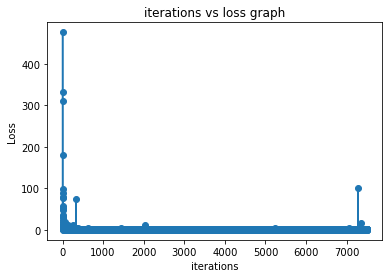

accuracy so far is  46.0  for batch size  4


In [134]:
# training on 720 samples to test the accuracy with ADAM optimizer, with batchnorm and dropout layers when both anuhya, shiva and aryan data mixed with batch size 8
_ = train_and_test_my_model_with_sample(1500,4,20,0.01, None,mixed)

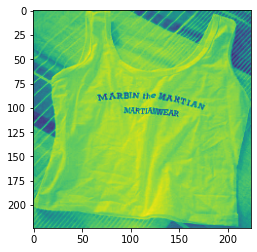

actual -  letter_numb 	predicted -  plain


In [135]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

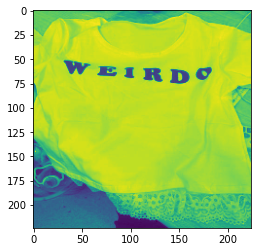

actual -  letter_numb 	predicted -  plain


In [136]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

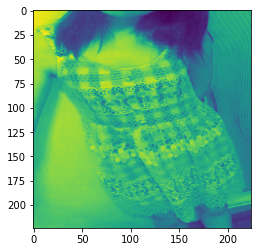

actual -  printed 	predicted -  plain


In [137]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

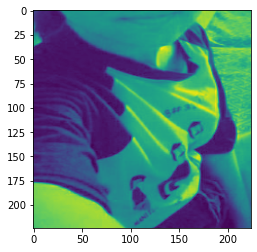

actual -  cartoon 	predicted -  plain


In [138]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

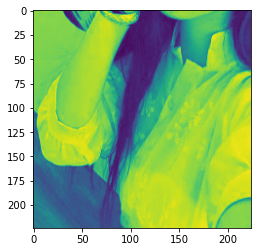

actual -  printed 	predicted -  plain


In [139]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

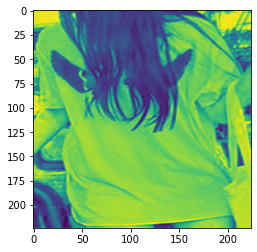

actual -  printed 	predicted -  plain


In [140]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

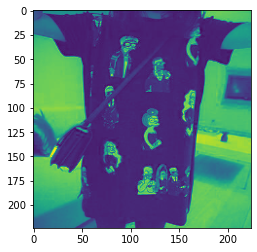

actual -  cartoon 	predicted -  plain


In [141]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

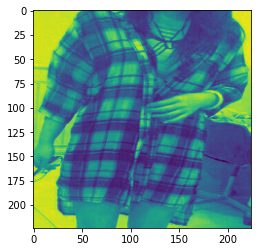

actual -  squares 	predicted -  plain


In [142]:
sample_checker(wrong_classifications,np.random.randint(0,len(wrong_classifications)))

In [143]:
path_to_csv = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/anuhya/1.csv'
path_to_images = 'C:/Users/shiva/OneDrive/Desktop/Machine Learning/Project/MLPROJECT/annotated data images-revised/anuhya/'

data = pd.read_csv(path_to_csv)

# sel = data['image']
# bboxes = df[df['image'].apply(lambda x: any(vals for vals in sel if vals in x))]['bounding_box']

# bboxes = bboxes.tolist()

bounding_lst = list()
for i in range(len(data)):
    bounding_lst.append((df[df['image']==data['image'][i]])['bounding_box'])
bboxes = list()
for i in range(len(bounding_lst)):
    bboxes.append(stringToList(list(bounding_lst[i])[0]))



df_images = []
for i in range(len(data['image'])):
    df_images.append((convertImageToTensorWithBBox(data['image'][i],bboxes[i]),classes[data['pattern'][i]]))

1  epoch - cost of the batch is :  17.532449011098254
2  epoch - cost of the batch is :  1.607245140454986
3  epoch - cost of the batch is :  1.513447179035707
4  epoch - cost of the batch is :  1.490223890678449
5  epoch - cost of the batch is :  1.4776579107750545
6  epoch - cost of the batch is :  1.4687826721505686
7  epoch - cost of the batch is :  1.4685535816983744
8  epoch - cost of the batch is :  1.5464206446300854
9  epoch - cost of the batch is :  1.4837431020357392
10  epoch - cost of the batch is :  1.4647456217895856


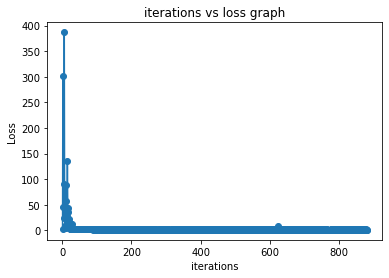

accuracy so far is  48.0  for batch size  4


In [148]:
_ = train_and_test_my_model_with_sample(350,4,10,0.01, None,df_images)

1  epoch - cost of the batch is :  21.70161026174372
2  epoch - cost of the batch is :  2.4370750080455434
3  epoch - cost of the batch is :  1.7088115513324738
4  epoch - cost of the batch is :  1.5381883057680996
5  epoch - cost of the batch is :  1.864180089397864
6  epoch - cost of the batch is :  3.065092821012844
7  epoch - cost of the batch is :  1.4570208191871643
8  epoch - cost of the batch is :  1.44965560734272
9  epoch - cost of the batch is :  1.4517019160769202
10  epoch - cost of the batch is :  1.4448499354449185


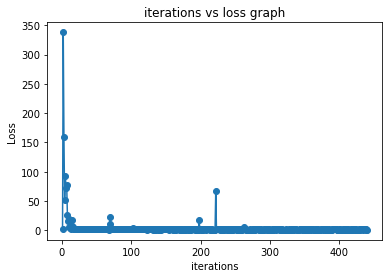

accuracy so far is  44.0  for batch size  8


In [149]:
_ = train_and_test_my_model_with_sample(350,8,10,0.01, None,df_images)

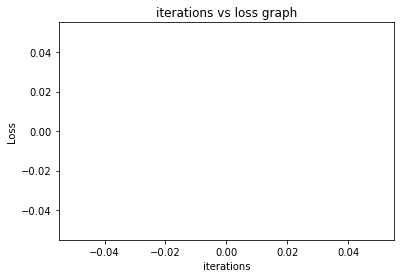

accuracy so far is  48.0  for batch size  8


In [157]:
#I set the crossentropy loss class reduction none
_ = train_and_test_my_model_with_sample(350,8,10,0.01, None,df_images)

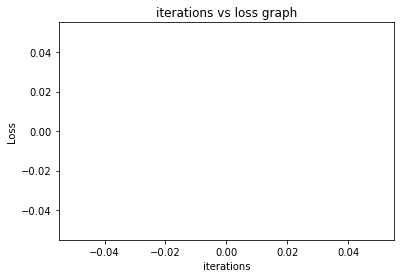

accuracy so far is  48.0  for batch size  4


In [158]:
#I set the crossentropy loss class reduction none
_ = train_and_test_my_model_with_sample(350,4,10,0.01, None,df_images)

**couldn't plot the graph when we used reduction and the accuracy is not at all improving even after using the reduction**

**I think its not working because i feel that the training data is having a collection of all items as we are taking them randomly, we just need to check if the model is performing properly for one image, that is to overfit it**